In [1]:
%pylab inline --no-import-all

/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


In [21]:
import george
from george.kernels import MyDijetKernelSimp, SignalKernel

import math
import time
import numpy as np
import scipy.stats as ss
import scipy.special as ssp
import scipy.optimize as op
from iminuit import Minuit
import corner

import ROOT as r
from rootpy.plotting import Hist, Hist2D, Legend, Canvas
import rootpy.plotting.root2matplotlib as rplt

### load inputs

In [4]:
#Full bin centers (xvalO), counts (yvalO), bin width (xerrO), and bin low edges (xlowO) from ATLAS
xvalO = np.load("newoutputs/xvalO.npy")
yvalO = np.load("newoutputs/yvalO.npy")
xerrO = np.load("newoutputs/xerrO.npy")
xlowO = list(np.load("newoutputs/xlowO.npy"))

#Same, but with bins with zero counts removed. GP fits better without zero counts
xval = np.load("newoutputs/xval.npy")
yval = np.load("newoutputs/yval.npy")
xerr = np.load("newoutputs/xerr.npy")

#hyperparameters (kernel and mean) from GP fit to ATLAS data.
fixedHyperparams = np.load("newoutputs/fixedHyperparams.npy")




### Gaussian signal function

In [5]:
def sig_model(x, N=1e5, mass=2000., width=100., xErr=xerr):
    return N*(np.exp(-(x-mass)**2/2/width/width)/np.sqrt(2*np.pi)/width)*xErr

### Calculate z values and chi squared 

In [7]:
def calcSignificance(Data, Bkg):
    pvals = []
    zvals = []
    chi2 = 0
    for i, nD in enumerate(Data):
        nB = Bkg[i]
        if nD != 0:
            if nB > nD:
                pval = 1.-ssp.gammainc(nD+1.,nB)
            else:
                pval = ssp.gammainc(nD,nB)
            prob = 1-2*pval
            if prob > -1 and prob < 1:
                zval = math.sqrt(2.)*ssp.erfinv(prob)
            else:
                zval = np.inf
            if zval > 100: zval = 20
            if zval < 0: zval = 0
            if (nD < nB): zval = -zval
        else: zval = 0
            
        zvals.append(zval)
        chi2 += ((nD - nB) ** 2 / abs(nB)) 
    return zvals, chi2

#### mean and variance of non-central chi2

In [8]:
def chi2_mean_variance(DOF, nc):
    mean = nc
    variance = np.sqrt(nc)
    return mean, variance

### Poisson log likelihood

In [9]:
def simpleLogPoisson(x, par):
    if x < 0: 
        return np.inf
    elif (x == 0): return -1.*par
    else:
        lnpoisson = x*np.log(par)-par-ssp.gammaln(x+1.) 
        return lnpoisson

### remove zero count bins to use for GP fits

In [10]:
def removeZeros(data):
    indices = [i for i, x in enumerate(data) if x == 0]
    newylist=[]
    newxlist=[]
    newxerrlist=[]
    for k in range(len(data)):
        if k not in indices:
            newylist.append(data[k])
            newxlist.append(xvalO[k])
            newxerrlist.append(xerrO[k])
    return np.array(newylist), np.array(newxlist), np.array(newxerrlist)

### fit for noncentrality parameter of non central chi-squared

In [11]:
def ncchi(x, nc):
    return ss.ncx2.pdf(x, 1., nc) 

### pretty plots showing background only fit and background+signal fit

In [12]:
def makePrettyPlots_signal(xs, ys, bkgs, bkgsigs, title, mass, col = 'g', ymax = 2e5):
    f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(12,12), gridspec_kw = {'height_ratios':[3, 1, 1]})
    f.suptitle(title, fontsize=40)
    dataPlot = ax1.errorbar(xs, ys, marker='o', ls='None', yerr = np.sqrt(ys), c='black', markersize=10, label="ATLAS data+Injected signal")
    bkg1Plot, = ax1.plot(xs, bkgs, color=col, linewidth=3.0, label="Background only")
    bkg2Plot, = ax1.plot(xs, bkgsigs, color='r', linewidth=3.0, label="Signal-plus-background")
    ax1.legend(prop={'size':20})
    ax1.set_ylabel('Events per bin', fontsize=40)
    ax1.set_yscale('log', nonposy="clip")
    ax1.set_xscale('log')
    ax1.set_xlim([1000, 7500])
    ax1.set_ylim([0.3, ymax])
    ax1.tick_params(axis='y', labelsize=30)
    ax1.axvline(mass, color='black', lw=1, linestyle="--")
    #ax1.arrow(mass, 1.5e2, 0, 3e2, lw=5, head_width=50, head_length=125)
    
    #bin by bin significance   
    zvals_1, chi2_1 = calcSignificance(ys, bkgs)
    print "chi2 bkg+signal mu=0", chi2_1
    h1 = Hist(xlowO,markersize=0)
    for x in range(len(zvals_1)):
        if zvals_1[x] == np.inf or zvals_1[x] == -np.inf: h1[x] = 20
        else: h1[x] = zvals_1[x]  
    h1.fillstyle = 'solid'
    if col == 'g':
         h1.fillcolor = 'green'
    elif col == 'b':
         h1.fillcolor = 'blue'
    elif col == 'r':
         h1.fillcolor = 'red'
    else:
        h1.fillcolor = 'black'
    h1.linecolor = 'black'
    h1.linewidth = 1
    h1.Draw("histX0")

    rplt.bar(h1, xerr=None, yerr=None, axes=ax2)
    ax2.axhline(0, color='black', lw=1)
    #ax2.set_ylabel('Significance', fontsize=20)
    ax2.set_ylabel('Sig.', fontsize=40, labelpad=20)
    ax2.set_xscale('log')
    ax2.tick_params(axis='y', labelsize=30)
    ax2.set_xlim([1000, 7500])
    ax2.set_ylim([-5, 5])
    ax2.axvline(mass, color='black', lw=1, linestyle="--")
    #ax2.arrow(mass, -3, 0, 1.7, lw=5,head_width=50, head_length=0.5)

    zvals_2, chi2_2 = calcSignificance(ys, bkgsigs)
    print "chi2 bkg+signal", chi2_2
    h2 = Hist(xlowO,markersize=0)
    for x in range(len(zvals_2)):
        if zvals_2[x] == np.inf or zvals_2[x] == -np.inf: h2[x] = 20
        else: h2[x] = zvals_2[x]  
    h2.fillstyle = 'solid'
    h2.fillcolor = 'red'
    h2.linecolor = 'black'
    h2.linewidth = 1
    h2.Draw("histX0")
    rplt.bar(h2, xerr=None, yerr=None, axes=ax3)
    ax3.axhline(0, color='black', lw=1)
    ax3.set_xlabel(r"$m_{jj}$ [TeV]", fontsize=40)
    #ax3.set_ylabel('Significance', fontsize=20)
    ax3.set_ylabel('Sig.', fontsize=40, labelpad=20)
    ax3.set_xscale('log')
    ax3.tick_params(axis='y', labelsize=30)
    ax3.tick_params(axis='x', labelsize=30)
    ax3.set_ylim([-5, 5])
    ax3.set_xlim([1000, 7500])
    ax3.axvline(mass, color='black', lw=1, linestyle="--")
    #ax3.arrow(mass, -3, 0, 1.7, lw=5,head_width=50, head_length=0.5)
    

    ax3.set_xticks([1000, 2000, 3000, 4000, 5000, 6000, 7000])
    ax3.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    minor_ticks = np.arange(1000, 7500, 100)
    ax3.set_xticks(minor_ticks, minor=True)  
    labels = ["1","2","3","4","5","6","7"]
    ax3.set_xticklabels(labels)
    
    f.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)    
    plt.show()


### plot distribution of log likelihood from fits to toys

In [13]:
def makePrettyPlots_LLH(GP_LLH, FF_LLH, title, drawchi2=False, xname=r'$\chi^{2}$', label1 = "Gaussian Process", label2 = "Fit Function"):
    f, (ax1, ax2) = plt.subplots(2, figsize=(12,12), gridspec_kw = {'height_ratios':[1, 1]})
    f.suptitle(title, fontsize=30)

    lowx = min(min(GP_LLH), min(FF_LLH))
    highx = max(max(GP_LLH), max(FF_LLH))
    bins = np.linspace(lowx, highx, 200)
    dx = bins[1]-bins[0]
    bin_centers = bins[:-1] + dx/2.
    
    hGP, _, _ = ax1.hist(GP_LLH, bins=bins, color="b")
    ax1.tick_params(axis='y', labelsize=20)
    ax1.tick_params(axis='x', labelsize=20)
    ax1.set_title(label1, fontsize=20)
    if drawchi2:
        bf_params_1, bf_cov_1 = op.curve_fit(ncchi, bin_centers, hGP)
        print "nc ", bf_params_1
        nc_chi = sum(hGP)*dx*ss.ncx2.pdf(bin_centers, 1., bf_params_1[0]) #bf_params[1]*
        ax1.plot(bin_centers, nc_chi, c='r', linewidth=2)
    
    
    hFF, _, _ =ax2.hist(FF_LLH, bins=bins, color='g')
    ax2.tick_params(axis='y', labelsize=20)
    ax2.tick_params(axis='x', labelsize=20)
    ax2.set_xlabel(xname, fontsize=30)
    ax2.set_title(label2, fontsize=20)
    if drawchi2:
        bf_params_2, bf_cov_2 = op.curve_fit(ncchi, bin_centers, hFF)
        print "nc ", bf_params_2
        nc_chi = sum(hFF)*dx*ss.ncx2.pdf(bin_centers, 1., bf_params_2[0]) #bf_params[1]*
        ax2.plot(bin_centers, nc_chi, c='r', linewidth=3)

    plt.show()
    return bf_params_1, bf_params_2



### Poisson likelihood to use for Gaussian Process, for 3 parameter fit functions, 3 parameter fit function with signal strength parameter, 5 parameter fit function, and 5 parameter fit function with signal strength parameter. 

In [14]:
def logLike_gpLikeFF(y1, y2):
    logL = 0
    for ibin in range(len(y1)):
        data = y1[ibin]
        bkg = y2[ibin]
        logL += -simpleLogPoisson(data, bkg)
    try:
        logL
        return logL
    except:
        return np.inf  
        


### mean function for GP - 3 parameter fit function. negative log likelihood for Gaussian Process - from george. Minuit minimzation for GP negative log likelihood. Hyperparameters and mean function parameters are fixed, just fitting signal strength

In [16]:
def model_gp(params, t, xerr=xerr): 
    p0, p1, p2 = params
    sqrts = 13000.
    return (p0 * (1.-t/sqrts)**p1 * (t/sqrts)**(p2))*xerr

class logLike_gp_tempSig_fixedH:
    def __init__(self, x, y, xerr):
        self.x = x
        self.y = y
        self.xerr = xerr
    def __call__(self, A, mass, tau, L):
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d = sub)
        kernel2 = A * SignalKernel(m = mass, t = tau, L=L)
        kernel = kernel1+kernel2
        gp = george.GP(kernel)
        try:
            gp.compute(self.x, np.sqrt(self.y))
            return -gp.lnlikelihood(self.y - model_gp((p0,p1,p2), self.x, self.xerr))
        except:
            return np.inf        
        
def fit_gp_tempSig_fixedH_minuit(lnprob, Print = True):
    minLLH = np.inf
    best_fit_params = (0, 0, 0, 0)
    passedFit = False
    numRetries = 0
    while not passedFit and numRetries < 5:
        init0 = np.random.random() * 1.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, 
                   N = init0, error_N = 1e-4, limit_N = (0, 100)) 
        fit = m.migrad()
        if fit[0]['is_valid']: 
            passedFit=True
        if m.fval < minLLH:
            minLLH = m.fval
            best_fit_params = m.args     
            
        if numRetries == 4: 
            print "retry number = ", 5, ": failed fits"
            minLLH=np.inf
            best_fit_params=(0)
        numRetries+=1
    if Print:
        print "min LL", minLLH
        print "best fit vals",best_fit_params
    return minLLH, best_fit_params




### fit Gaussian Process background only and background plus signal on toys with injected signal. Check Poisson likelihood as well as george Gaussian likelihood. Hyperparameters and mean function parameters are fixed

(2000, 2000, 250)
chi2 bkg+signal mu=0 137.906790561
chi2 bkg+signal 65.2947298255


/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


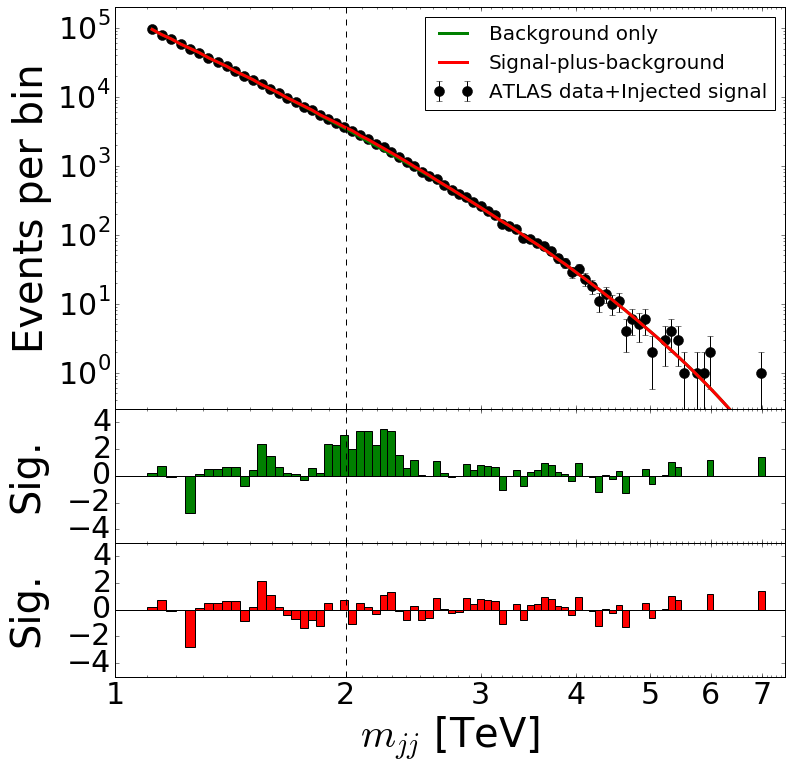

(700, 2500, 250)
chi2 bkg+signal mu=0 107.269615689
chi2 bkg+signal 65.2713274002


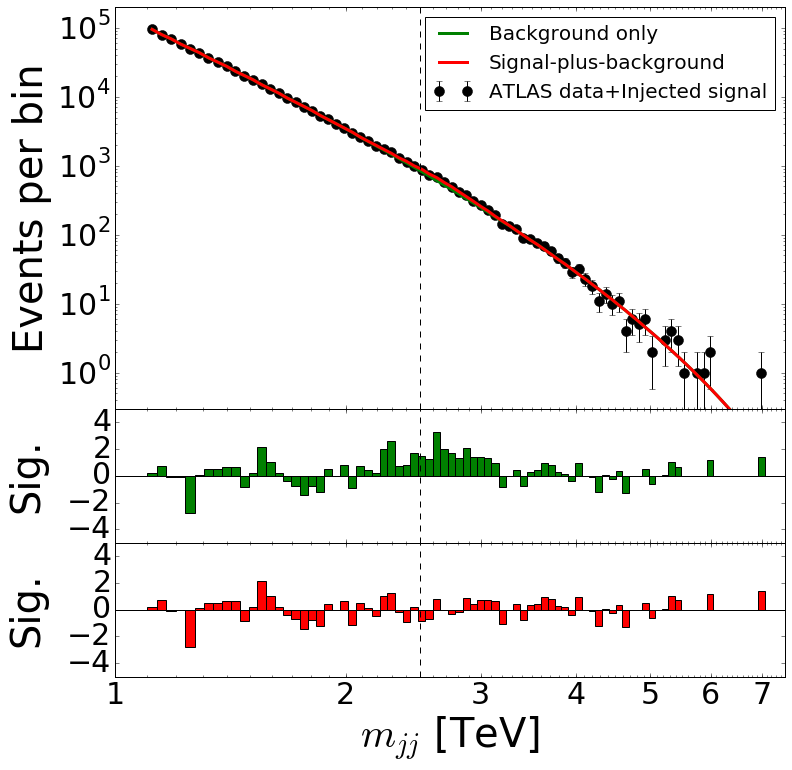

(250, 3000, 250)
chi2 bkg+signal mu=0 94.3842706654
chi2 bkg+signal 64.6766265888


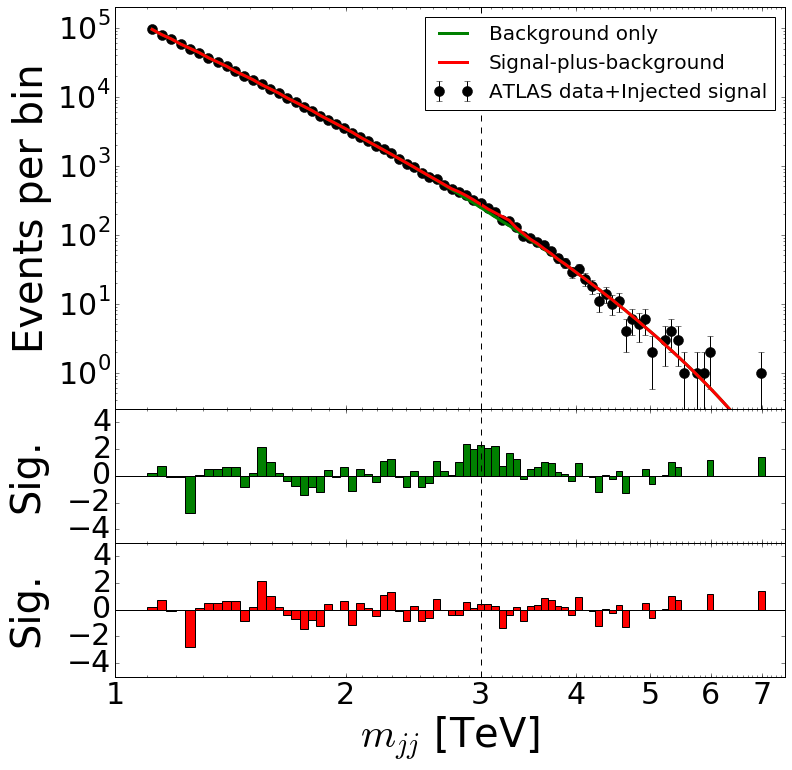

(125, 3500, 250)
chi2 bkg+signal mu=0 90.8550240972
chi2 bkg+signal 64.6179298906


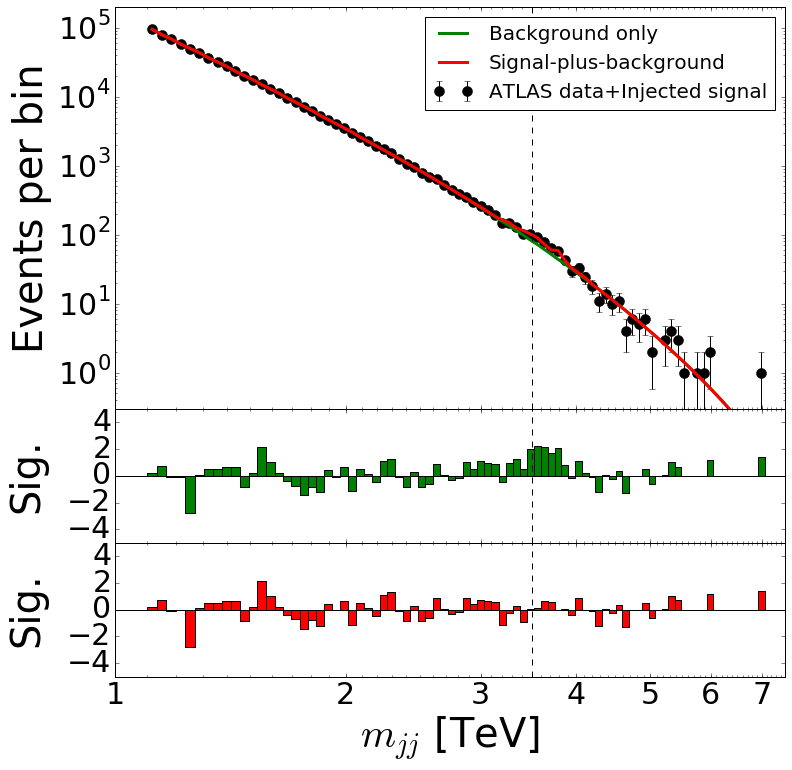

(70, 4000, 250)
chi2 bkg+signal mu=0 87.2070657483
chi2 bkg+signal 65.1131271869


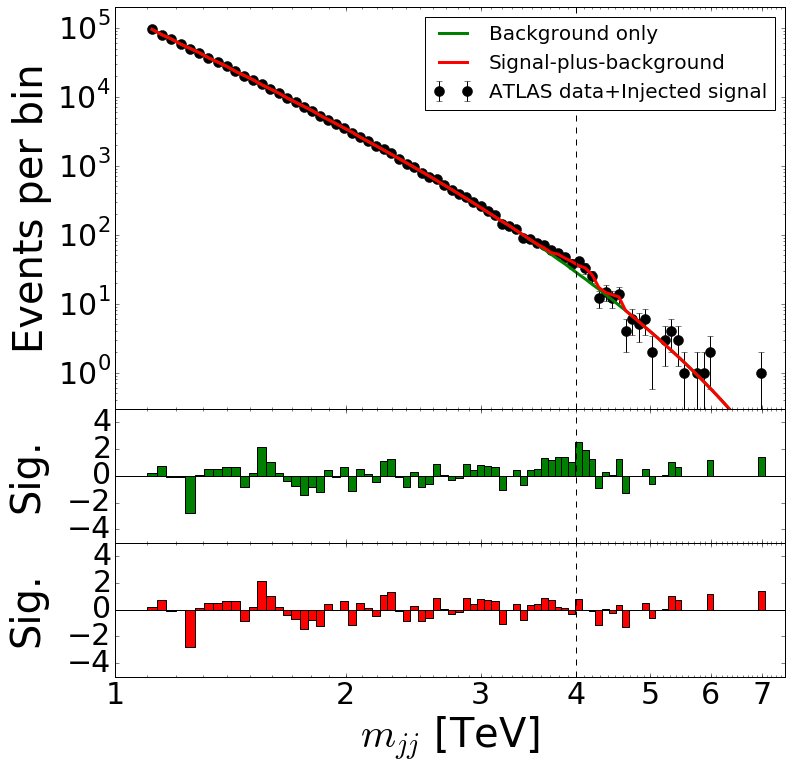

(40, 4500, 250)
chi2 bkg+signal mu=0 80.7904857609
chi2 bkg+signal 64.4200229449


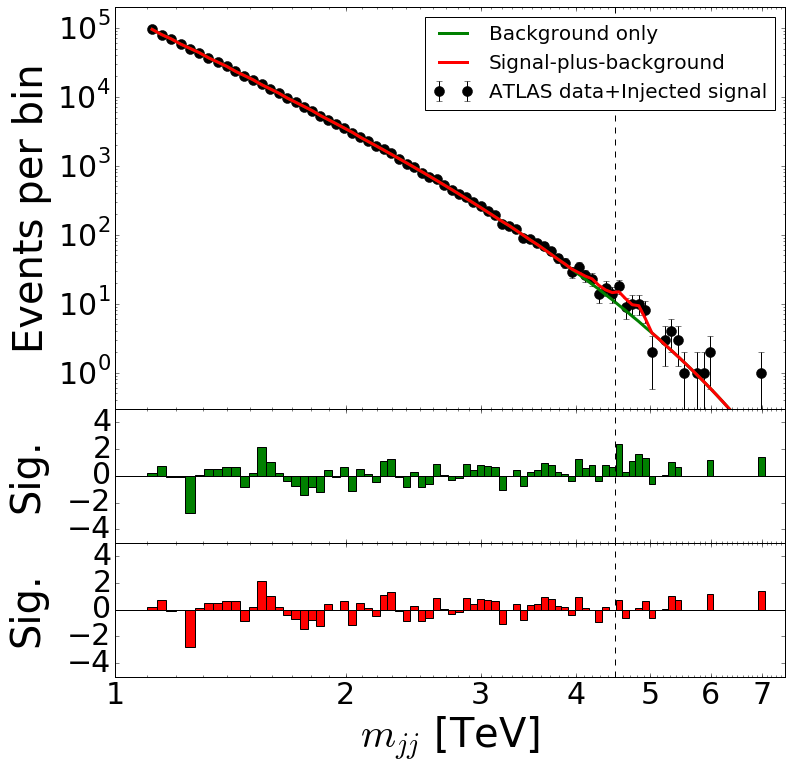

(25, 5000, 250)
chi2 bkg+signal mu=0 86.9408845275
chi2 bkg+signal 62.2461709141


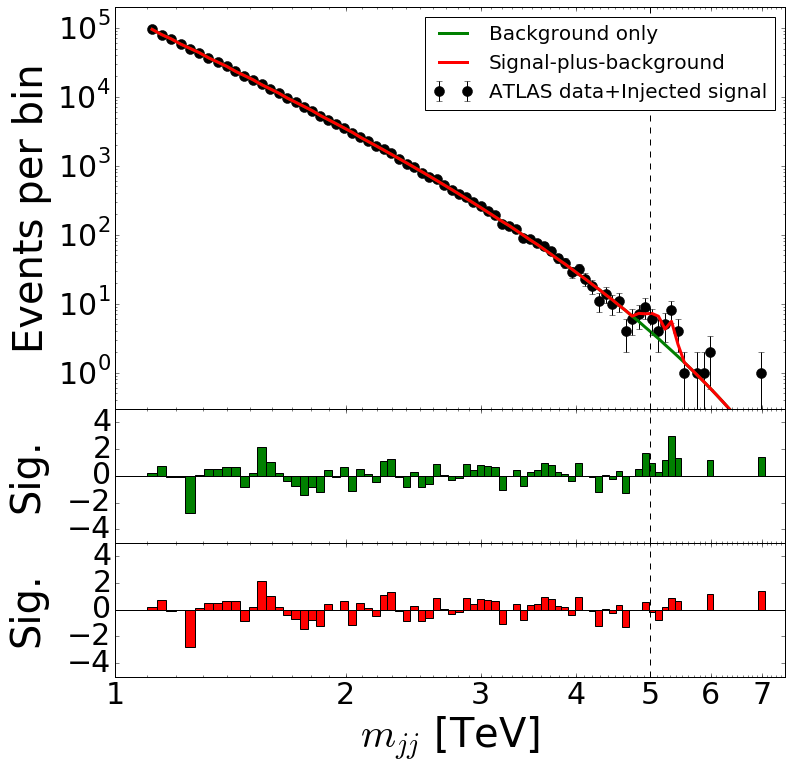

(15, 5500, 250)
chi2 bkg+signal mu=0 103.118236028
chi2 bkg+signal 61.8170398859


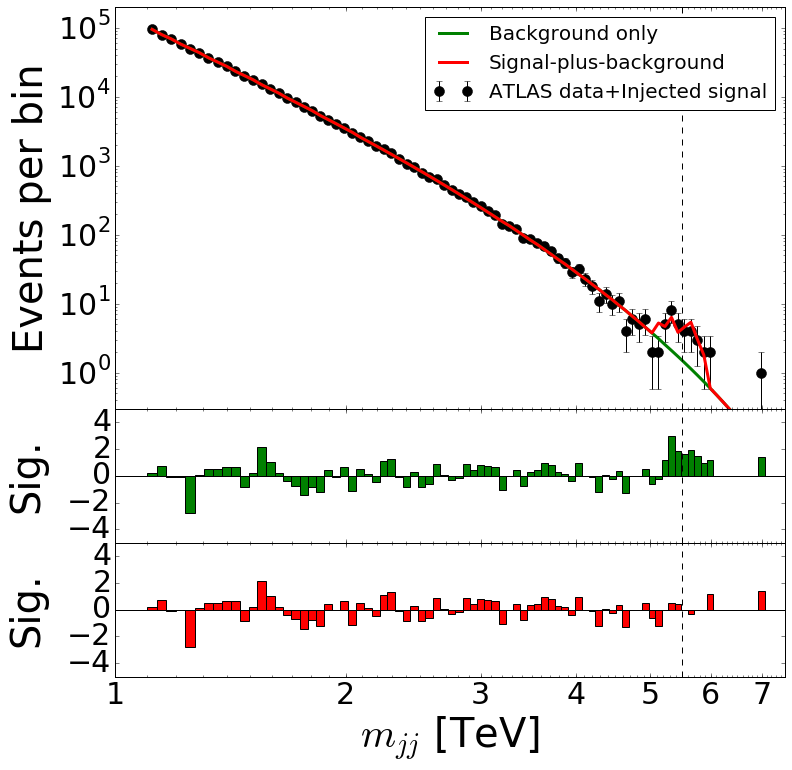

(10, 6000, 250)
chi2 bkg+signal mu=0 109.896462614
chi2 bkg+signal 65.0501212674


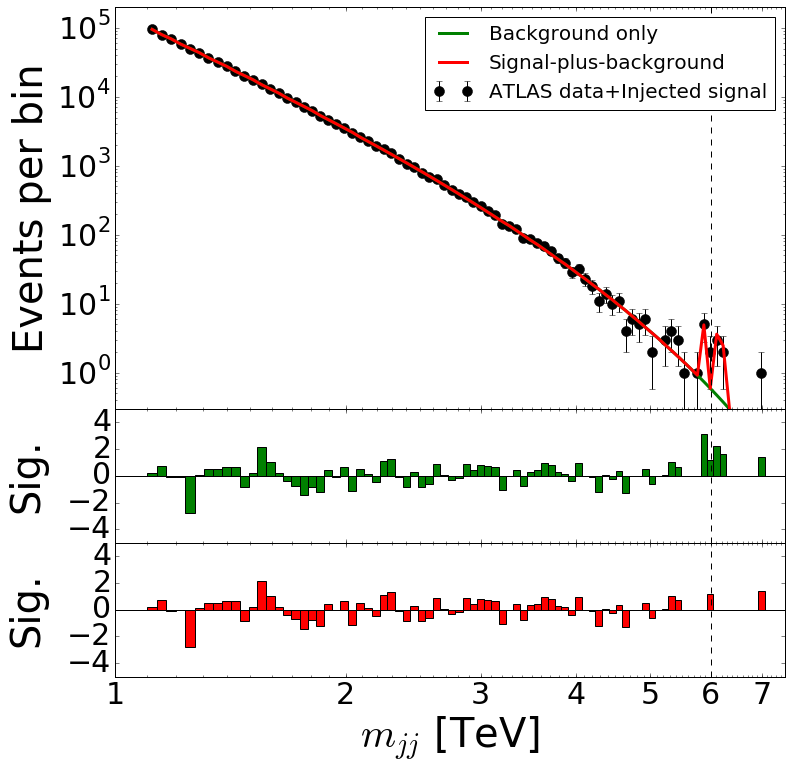

In [17]:
for pSet in standardParamSets:
    n, m, w = pSet
    print pSet

    ytoy, xtoy, xtoyerr = removeZeros(yvalO)
    signalTemplate = sig_model(xtoy, n, m, w, xtoyerr)
    signalTemplate = np.random.poisson(np.around(signalTemplate))
    ydata = ytoy + signalTemplate

    signalTemplateO = sig_model(xvalO, n, m, w, xerrO)
    signalTemplateO = np.random.poisson(np.around(signalTemplateO))
    ydataO = yvalO + signalTemplateO

    #BACKGROUND ONLY FIT GP
    Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
    kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d = sub)
    gp1 = george.GP(kernel1)
    gp1.compute(xtoy, np.sqrt(ydata))
    MAP1p, covGP1 = gp1.predict(ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)
    MAP1 = MAP1p + model_3param(xvalO,(p0,p1,p2),xerrO)
    gpLLH = gp1.lnlikelihood(ydata - model_gp((p0,p1,p2),xtoy, xtoyerr))

    lnProb = logLike_gp_tempSig_fixedH(xtoy,ydata, xtoyerr, signalTemplate)
    minimumLLH, best_fit_gp = fit_gp_tempSig_fixedH_minuit(lnProb, False)
    if np.isinf(minimumLLH): continue
    mu = best_fit_gp[0]

        
    kernel = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d = sub)
    gp = george.GP(kernel)
    gp.compute(xtoy, np.sqrt(ydata))
    MAPp, covGP = gp.predict(ytoy - model_gp((p0,p1,p2),xtoy, xtoyerr) - mu*signalTemplate, xvalO)
    MAP = MAPp+ model_3param(xvalO,(p0,p1,p2),xerrO)
    MAPsig = MAP+mu*signalTemplateO
    gpLLHSig = gp.lnlikelihood(ydata - model_gp((p0,p1,p2),xtoy, xtoyerr) - mu*signalTemplate)
    makePrettyPlots_signal(xvalO, ydataO, MAP, MAPsig, "", m, col = 'g', ymax = 2e5)


### Distribution of log likelihood ratio for Gaussian Process from george and Poisson likelihood calculations, with non central chi2 overlaid

(300, 3500, 250)
0
background only time: 0.00320100784302
background + signal time: 0.00367712974548
chi2 bkg+signal mu=0 208.744343006
chi2 bkg+signal 191.702563695


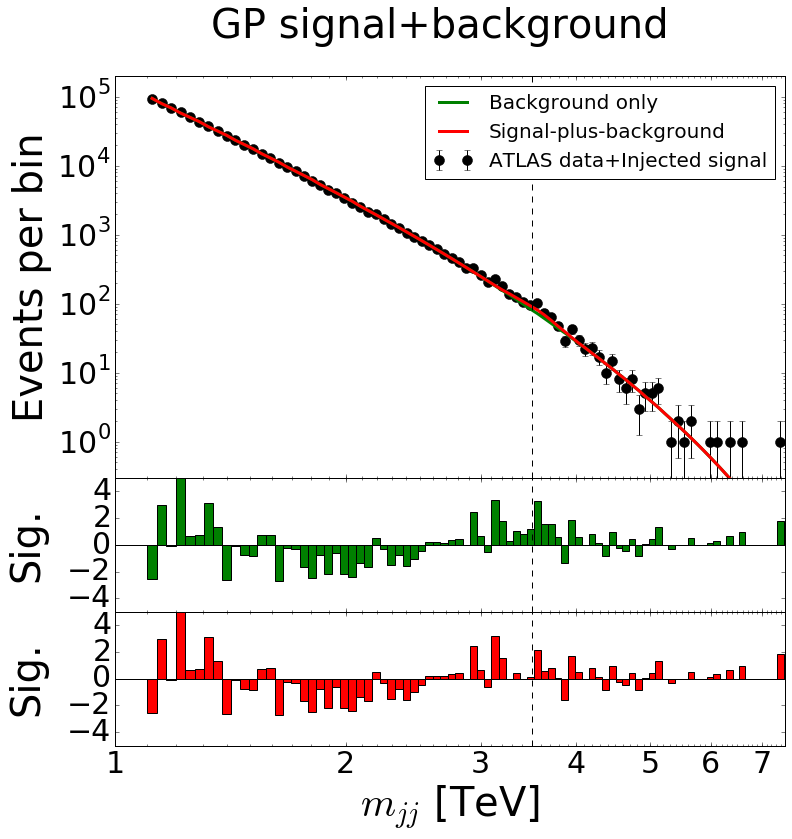

500
background only time: 0.00367307662964
background + signal time: 0.00384998321533
chi2 bkg+signal mu=0 255.23475803
chi2 bkg+signal 251.890639231


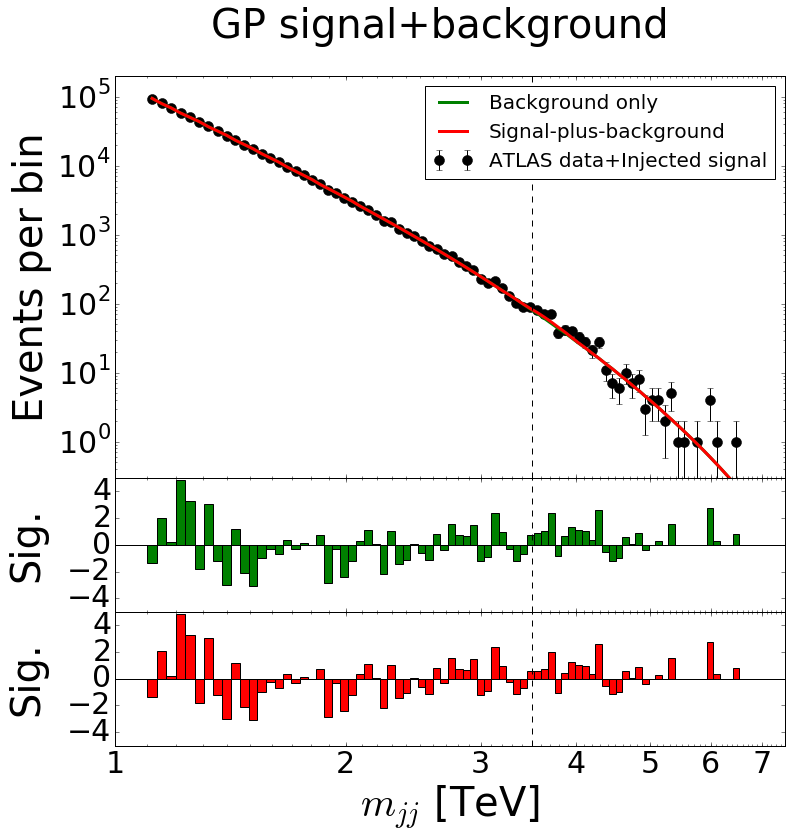

1000
background only time: 0.00326108932495
background + signal time: 0.00406312942505
chi2 bkg+signal mu=0 188.383188689
chi2 bkg+signal 182.943655792


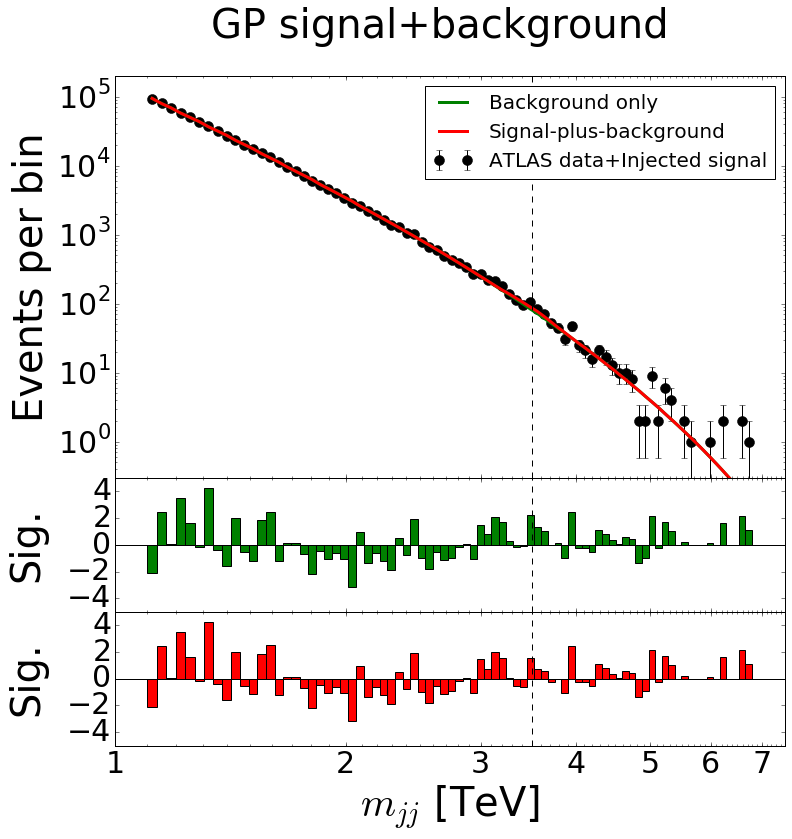

1500
background only time: 0.00330495834351
background + signal time: 0.00373196601868
chi2 bkg+signal mu=0 156.71742087
chi2 bkg+signal 152.274176505


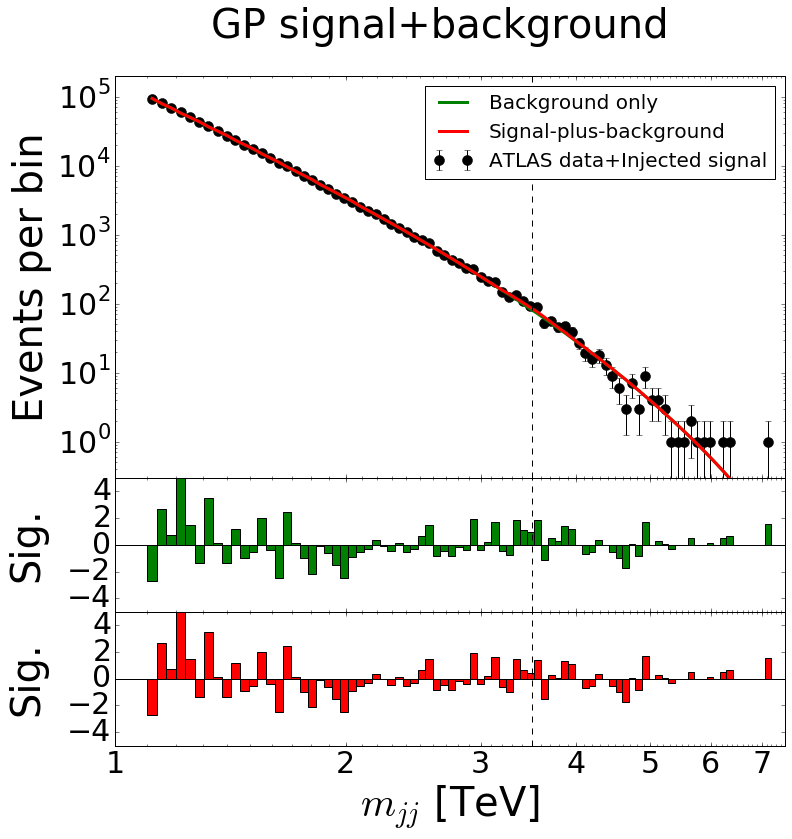

2000
background only time: 0.00312900543213
background + signal time: 0.00353789329529
chi2 bkg+signal mu=0 206.619007664
chi2 bkg+signal 203.917666141


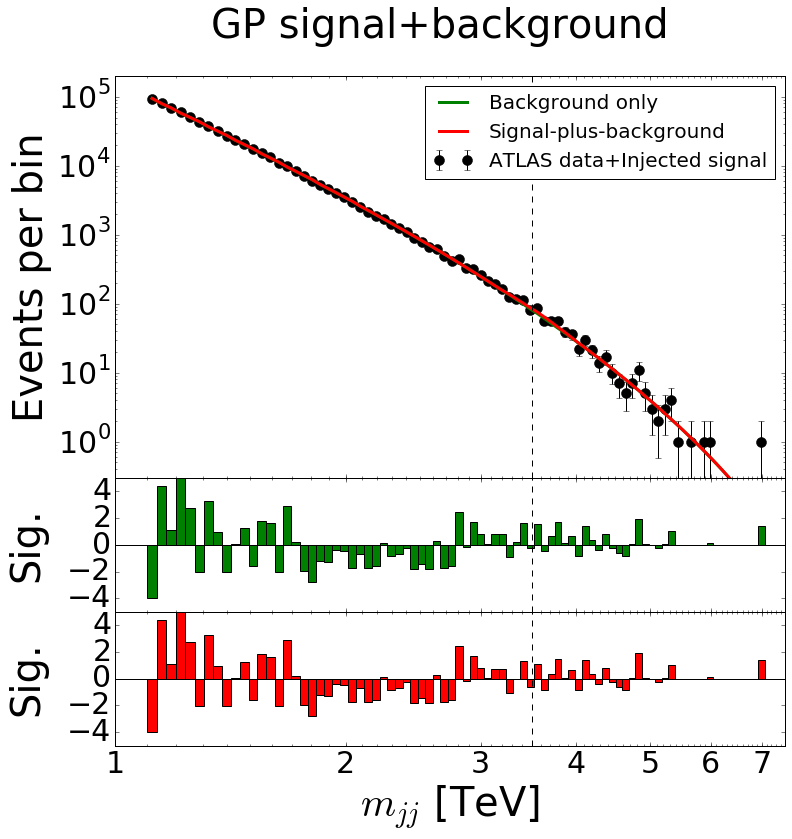

2500
background only time: 0.00320601463318
background + signal time: 0.00341391563416
chi2 bkg+signal mu=0 123.019727125
chi2 bkg+signal 121.586035266


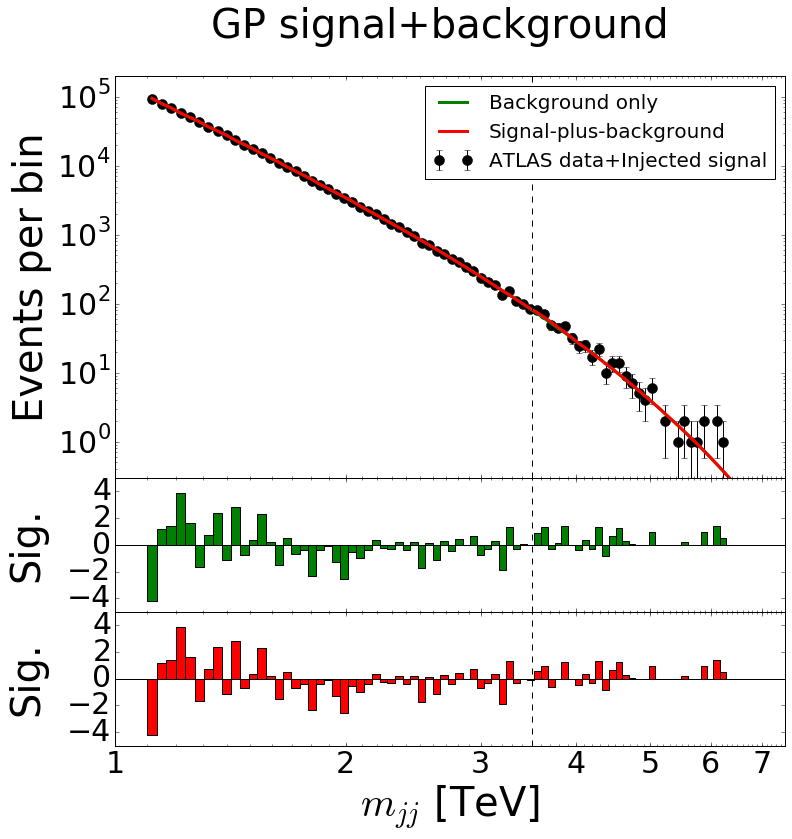

3000
background only time: 0.00310206413269
background + signal time: 0.00381398200989
chi2 bkg+signal mu=0 142.453859398
chi2 bkg+signal 141.842916782


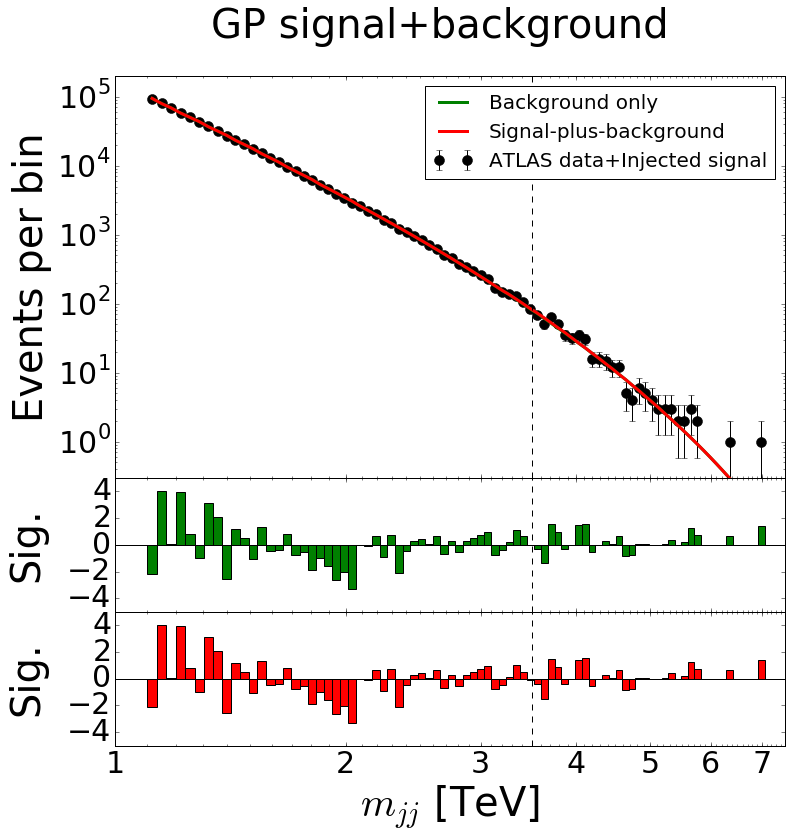

3500
background only time: 0.00367093086243
background + signal time: 0.00450587272644
chi2 bkg+signal mu=0 165.358687785
chi2 bkg+signal 163.856955226


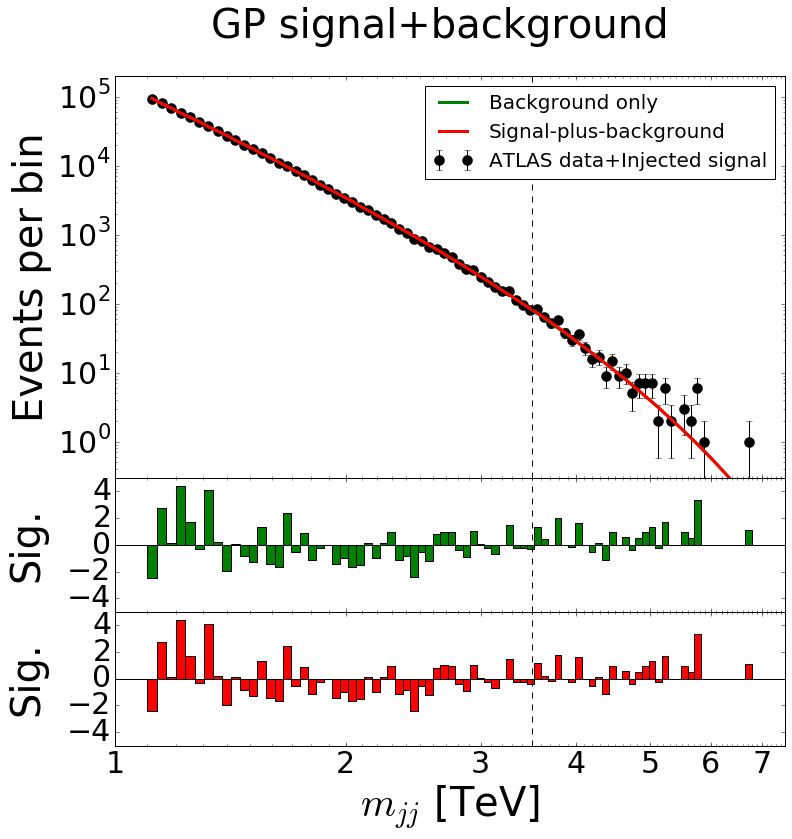

4000
background only time: 0.00290203094482
background + signal time: 0.00340795516968
chi2 bkg+signal mu=0 170.082585653
chi2 bkg+signal 168.135621164


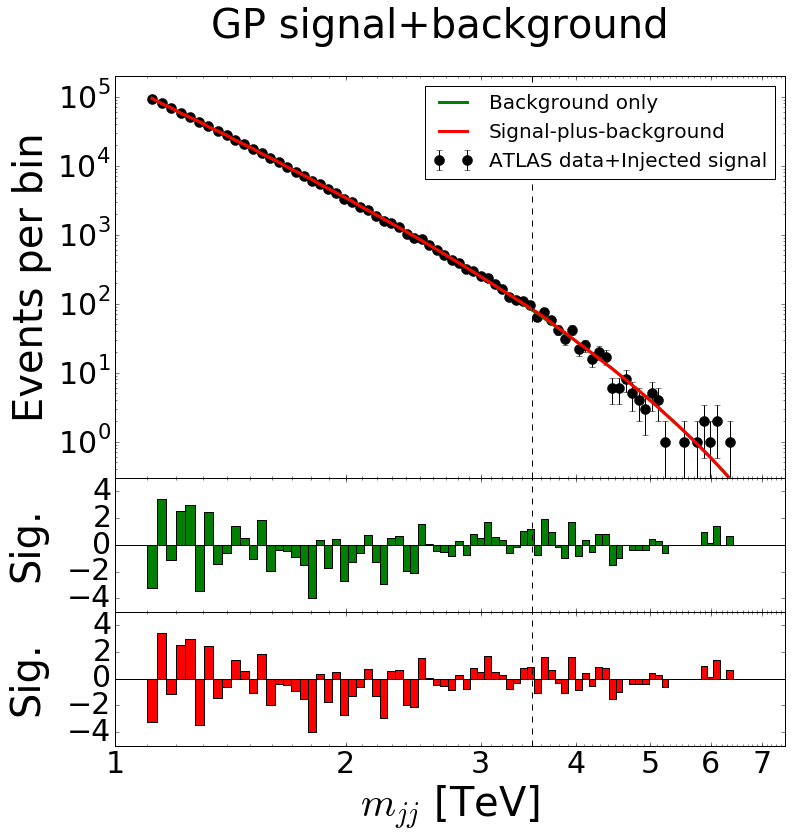

4500
background only time: 0.00299191474915
background + signal time: 0.00349688529968
chi2 bkg+signal mu=0 190.981824715
chi2 bkg+signal 183.574754796


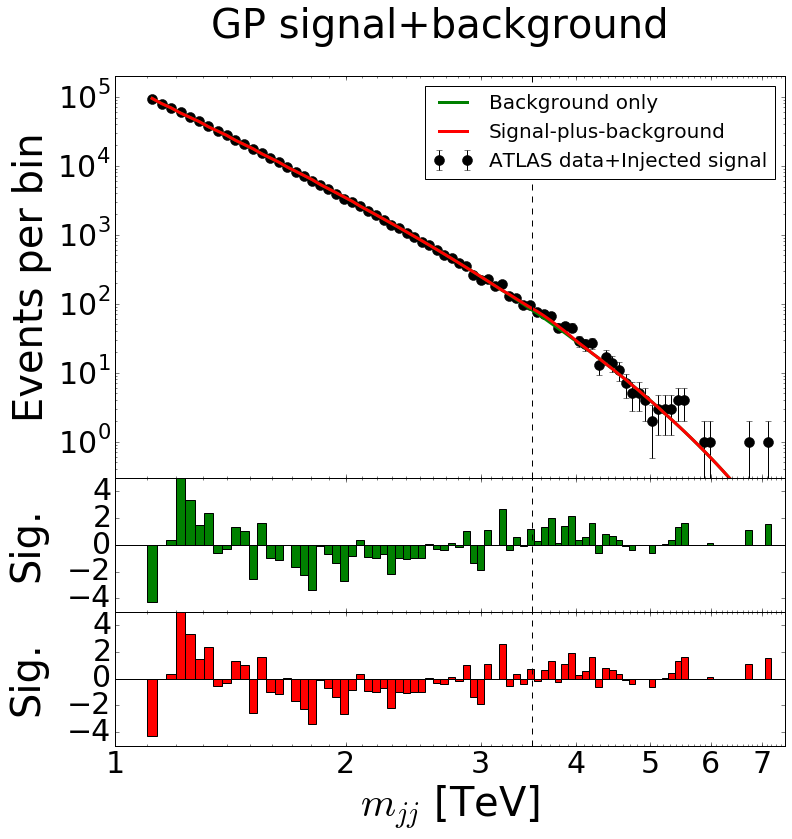

5000
background only time: 0.00383591651917
background + signal time: 0.00488996505737
chi2 bkg+signal mu=0 124.233254981
chi2 bkg+signal 123.628517561


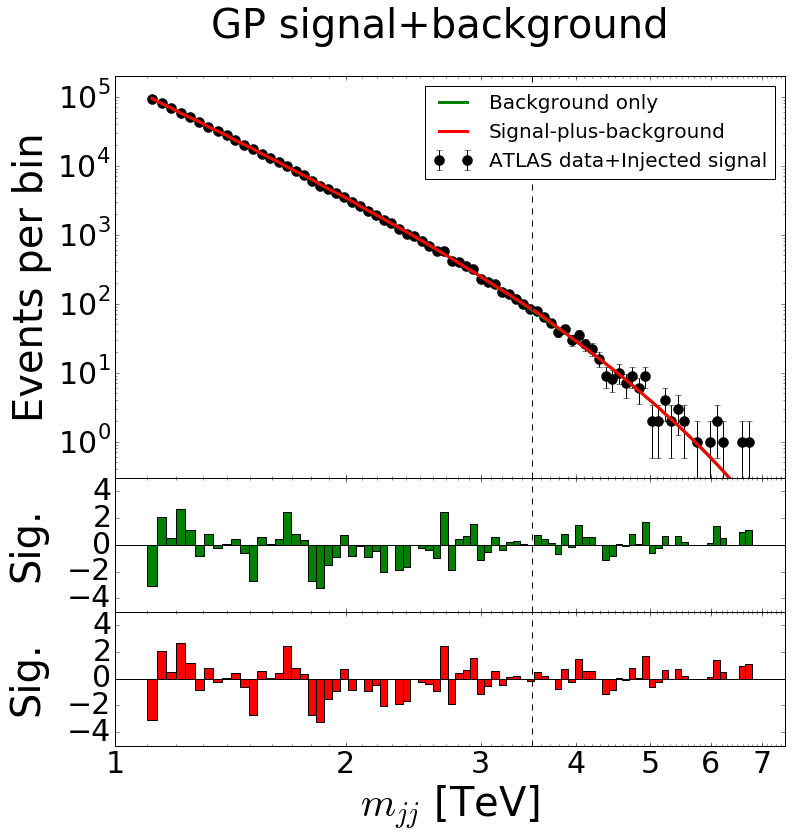

5500
background only time: 0.00361800193787
background + signal time: 0.00370407104492
chi2 bkg+signal mu=0 193.151028895
chi2 bkg+signal 187.50761046


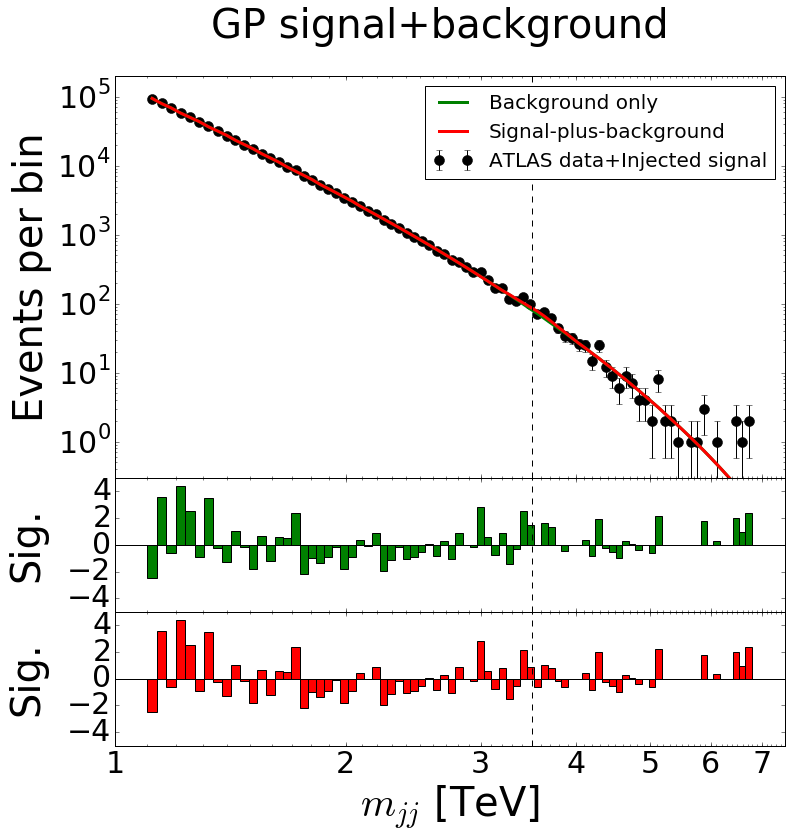

6000
background only time: 0.00325584411621
background + signal time: 0.00365996360779
chi2 bkg+signal mu=0 231.594001778
chi2 bkg+signal 227.749185712


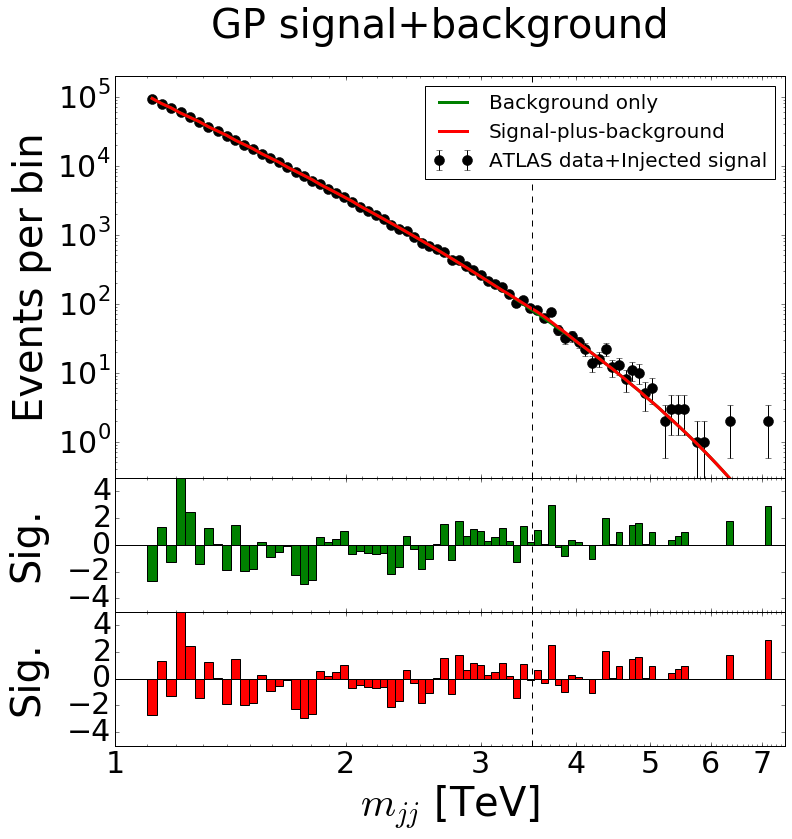

6500
background only time: 0.00307083129883
background + signal time: 0.00358700752258
chi2 bkg+signal mu=0 193.372404827
chi2 bkg+signal 187.088734019


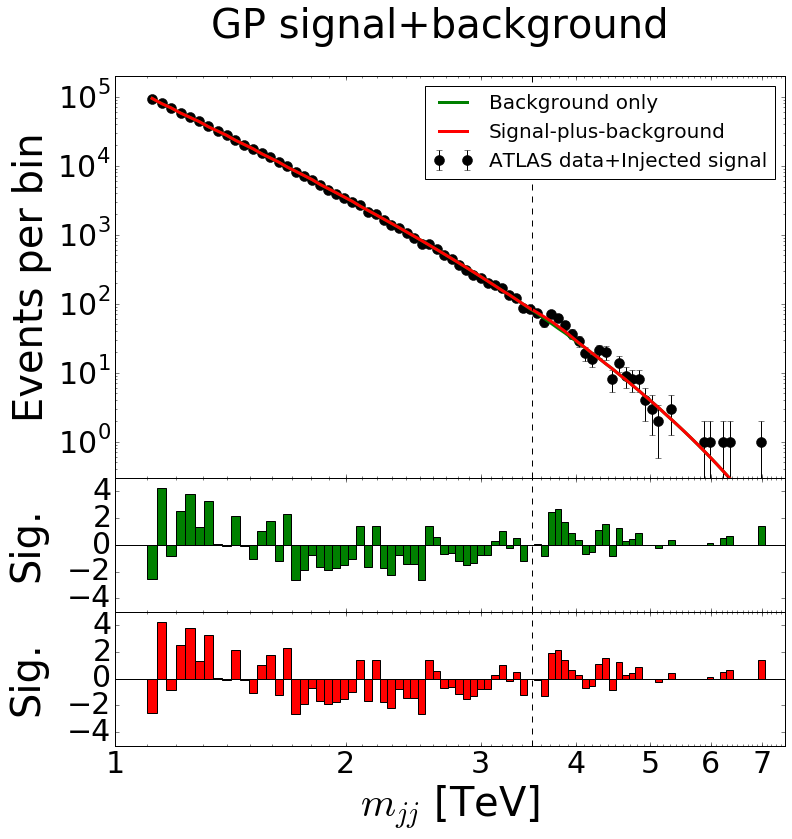

7000
background only time: 0.00296711921692
background + signal time: 0.00342988967896
chi2 bkg+signal mu=0 156.091004313
chi2 bkg+signal 155.514096676


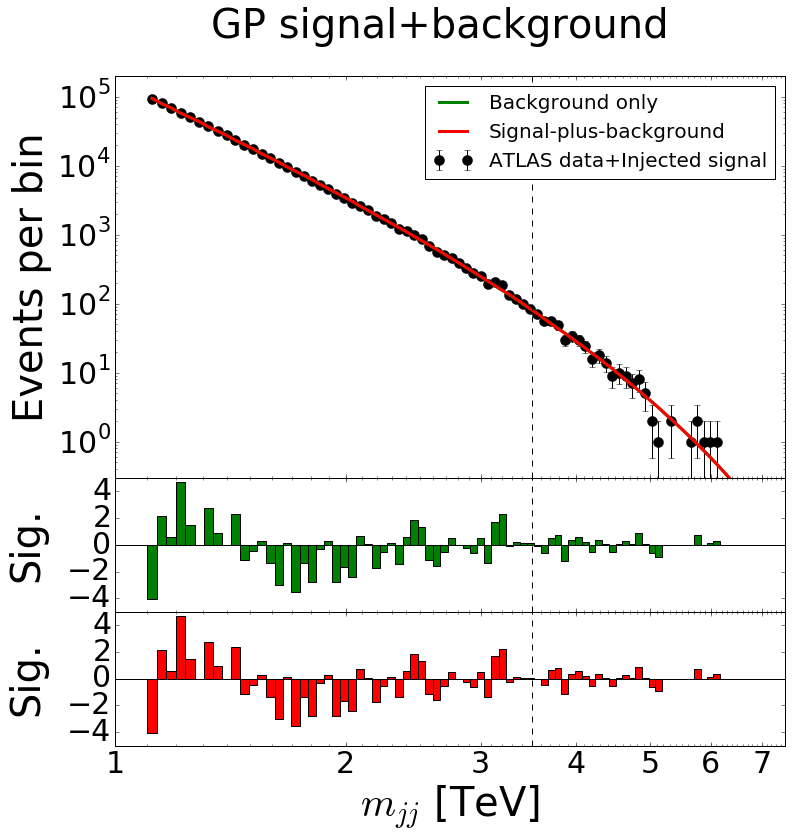

7500
background only time: 0.00293302536011
background + signal time: 0.00346207618713
chi2 bkg+signal mu=0 144.166540606
chi2 bkg+signal 142.3867212


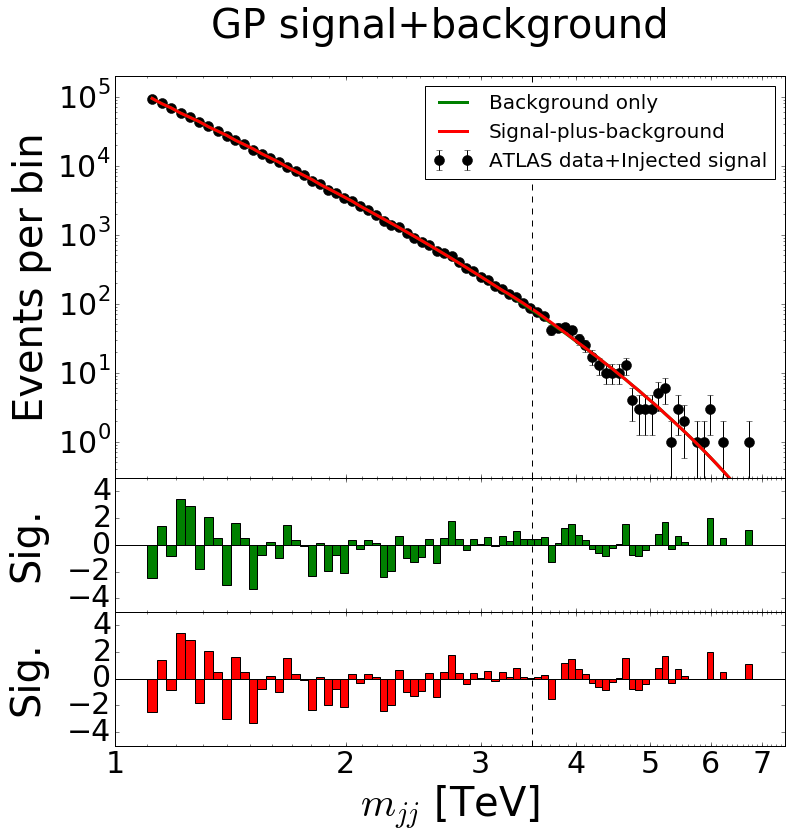

8000
background only time: 0.00296306610107
background + signal time: 0.0034921169281
chi2 bkg+signal mu=0 227.293228764
chi2 bkg+signal 220.1134153


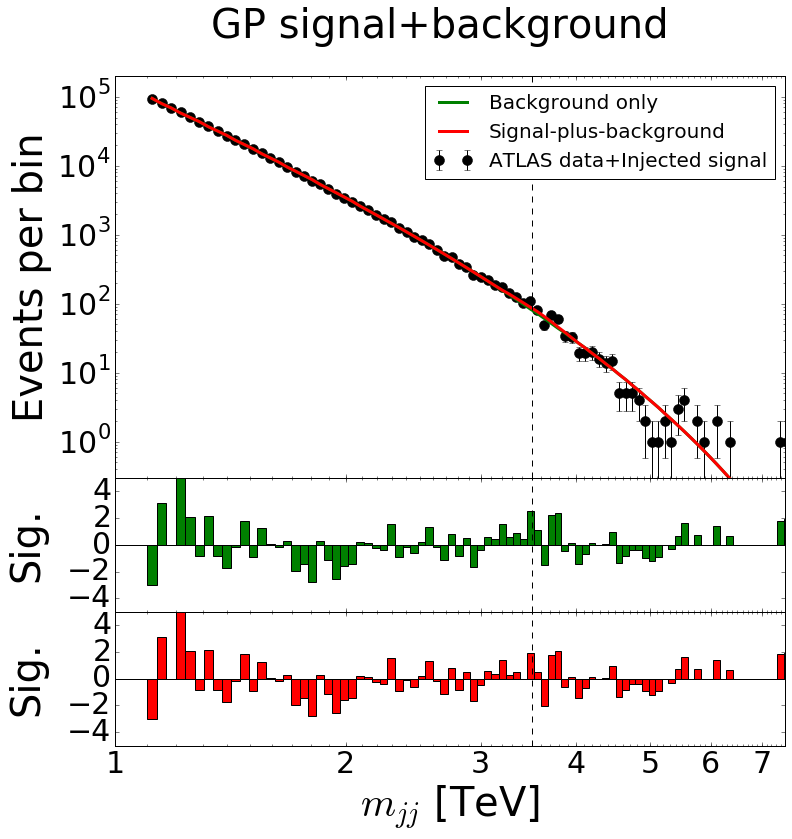

8500
background only time: 0.00353813171387
background + signal time: 0.00349617004395
chi2 bkg+signal mu=0 240.578312891
chi2 bkg+signal 228.02611398


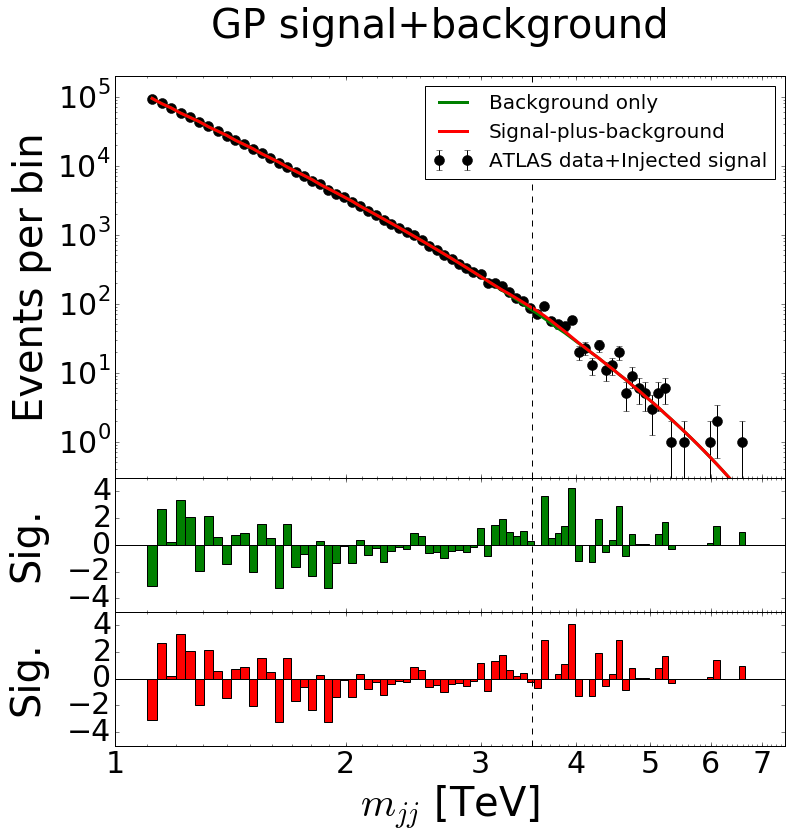

9000
background only time: 0.00293517112732
background + signal time: 0.00340509414673
chi2 bkg+signal mu=0 154.025770042
chi2 bkg+signal 154.109982777


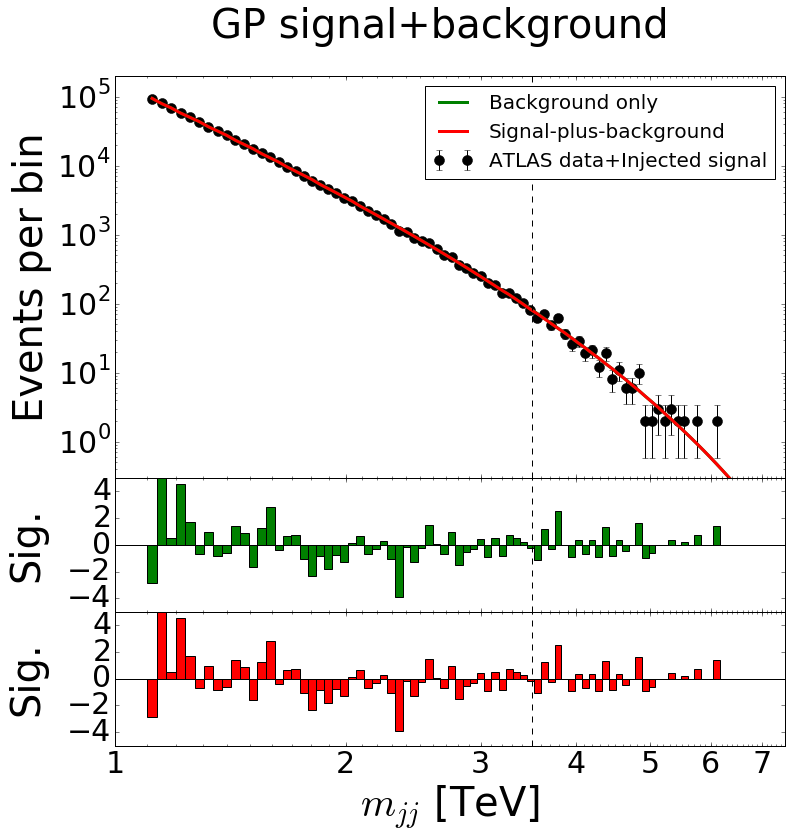

9500
background only time: 0.00289797782898
background + signal time: 0.00346779823303
chi2 bkg+signal mu=0 166.080659072
chi2 bkg+signal 164.771259543


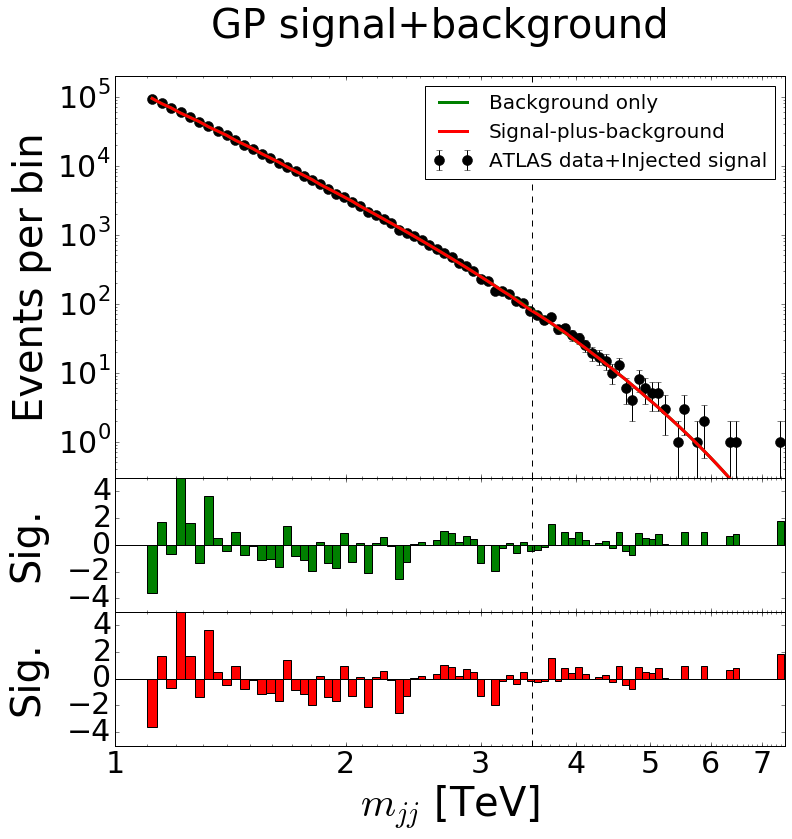

took 0.033676093022hours


In [29]:
sigToys = np.load("newoutputs/signalToys_3500.npy")
sigToysO = np.load("newoutputs/signalToysO_3500.npy")
toyList = np.load("newoutputs/toyList_3500.npy")
if runOnlyFF: pass
else: 
    btime=time.time()

    #LLH ratio george likelihood
    LLlistGP_largeL={}


    standardParamSets = [(300, 3500, 250)]
    for pSet in standardParamSets:
        n, m, w = pSet
        print pSet
        LLlistGP_largeL[m]=[]

        
        for itoy, toy in enumerate(toyList):
            if not itoy%500: 
                print itoy
            ytoy, xtoy, xtoyerr = removeZeros(toy)
            signalTemplate = sigToys[()][m][itoy]
            ydata = ytoy + signalTemplate

            signalTemplateO = sigToysO[()][m][itoy]
            ydataO = toy + signalTemplateO

            #BACKGROUND ONLY FIT GP
            if not itoy%500:
                pgpb_stime = time.time()
            Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
            kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d = sub)
            gp1 = george.GP(kernel1)
            gp1.compute(xtoy, np.sqrt(ydata))
            MAP1p, covGP1 = gp1.predict(ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)
            MAP1 = MAP1p + model_3param(xvalO,(p0,p1,p2),xerrO)
            gpLLH = gp1.lnlikelihood(ydata - model_gp((p0,p1,p2),xtoy, xtoyerr))
            if not itoy%500:
                pgpb_etime = time.time()
                print "background only time:", pgpb_etime-pgpb_stime

            #BACKGROUND+SIGNAL FIT GP
            if not itoy%500:
                pgpsb_stime = time.time()
            Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
            A, mass, tau, L = 30, 3500, 250, 250
            kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d = sub)
            kernel2 = A * SignalKernel(m = mass, t = tau, L=L)
            kernel = kernel1+kernel2
            gp = george.GP(kernel)
            gp.compute(xtoy, np.sqrt(ydata))
            MAPp, covGP = gp.predict(ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)
            MAP = MAPp + model_3param(xvalO,(p0,p1,p2),xerrO)
            gpLLHSig = gp.lnlikelihood(ydata - model_gp((p0,p1,p2),xtoy, xtoyerr))

            if not itoy%500:
                pgpsb_etime = time.time()
                print "background + signal time:", pgpsb_etime - pgpsb_stime
                makePrettyPlots_signal(xvalO, ydataO, MAP1, MAP, "GP signal+background", 3500, col = 'g', ymax = 2e5)
        

            LLlistGP_largeL[m].append(-2*(gpLLH-gpLLHSig))

    etime = time.time()
    print "took "+str((etime-btime)/(60.*60.)) + "hours"  

(300, 3500, 250)
0
background only time: 0.00429701805115
background + signal time: 0.00627088546753
chi2 bkg+signal mu=0 208.744343006
chi2 bkg+signal 198.77114455


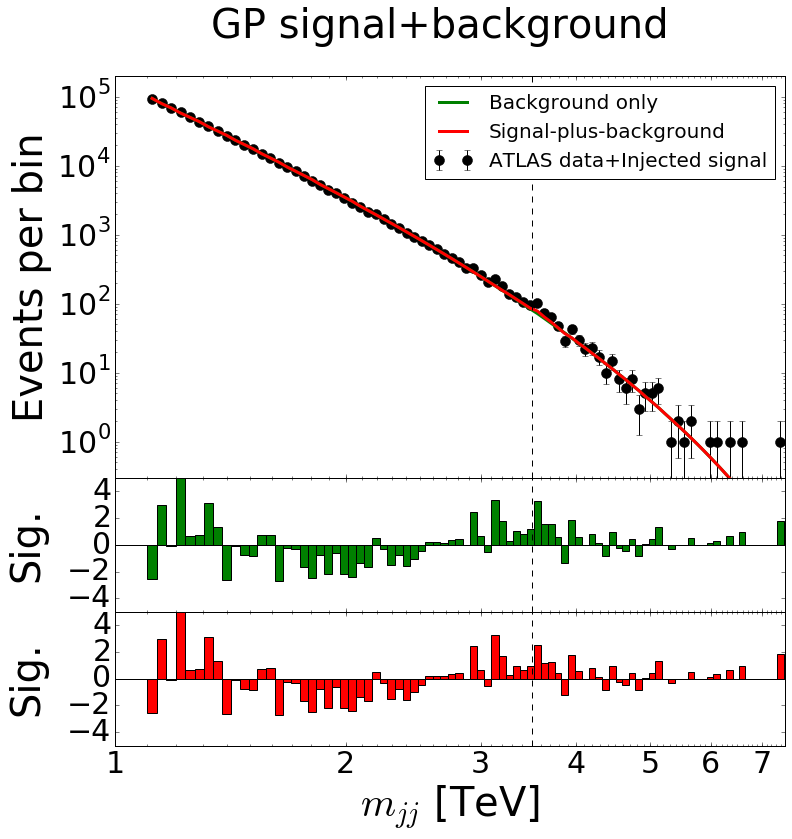

500
background only time: 0.00303101539612
background + signal time: 0.00345683097839
chi2 bkg+signal mu=0 255.23475803
chi2 bkg+signal 250.367211947


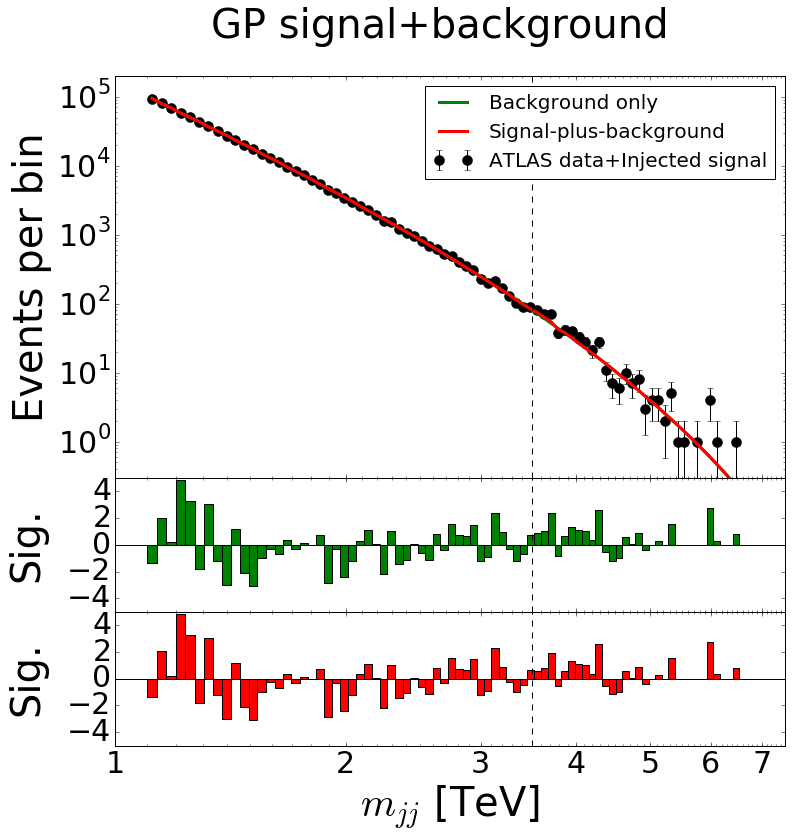

1000
background only time: 0.00288891792297
background + signal time: 0.00345897674561
chi2 bkg+signal mu=0 188.383188689
chi2 bkg+signal 183.483983386


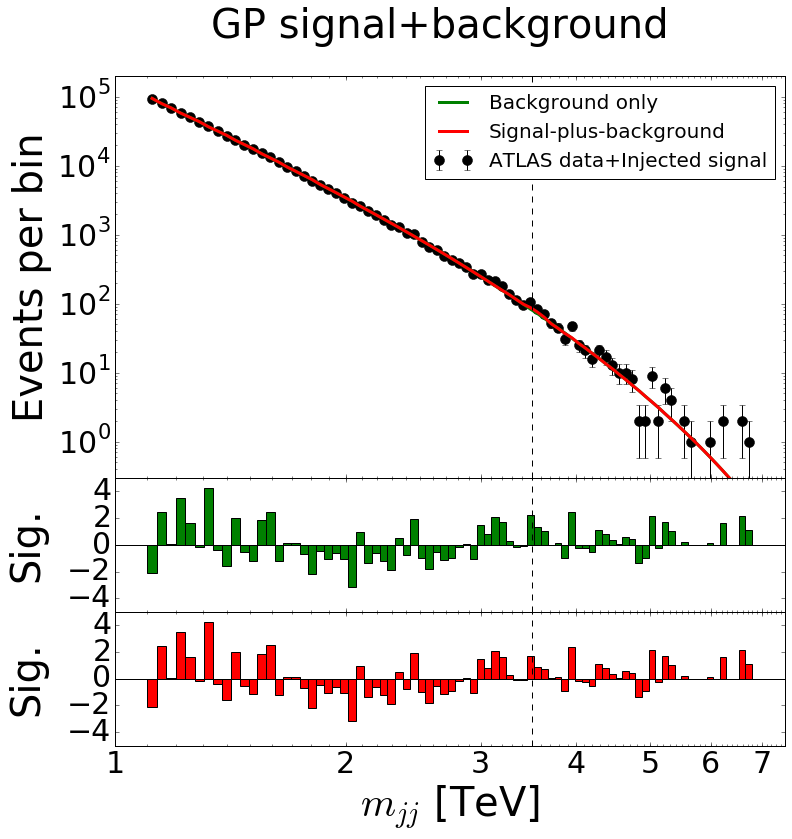

1500
background only time: 0.00303196907043
background + signal time: 0.00353813171387
chi2 bkg+signal mu=0 156.71742087
chi2 bkg+signal 151.145215468


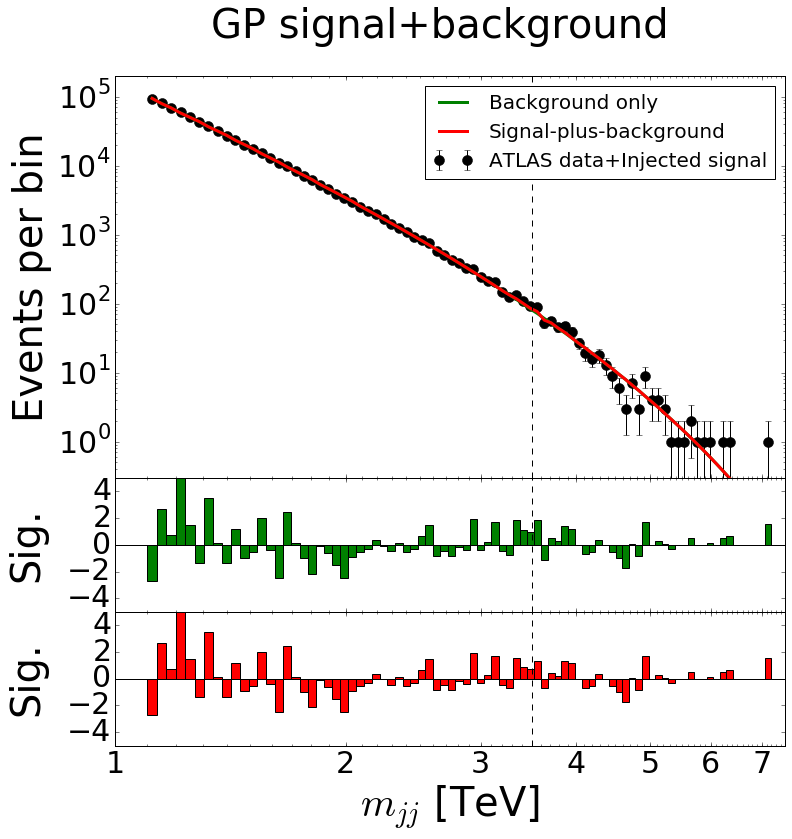

2000
background only time: 0.00289702415466
background + signal time: 0.00340104103088
chi2 bkg+signal mu=0 206.619007664
chi2 bkg+signal 203.037694828


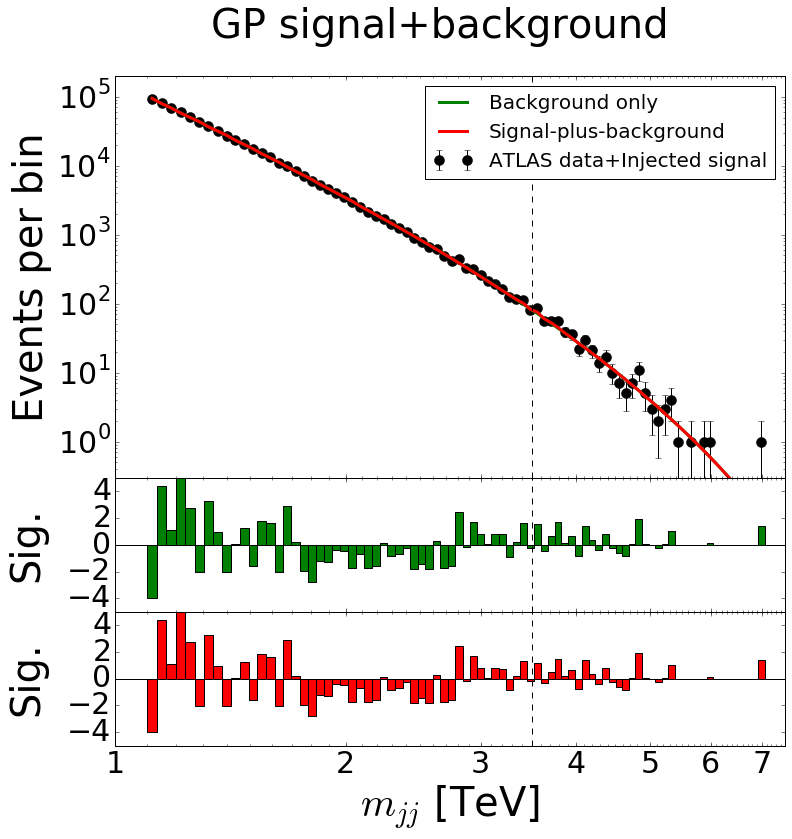

2500
background only time: 0.00292181968689
background + signal time: 0.00339913368225
chi2 bkg+signal mu=0 123.019727125
chi2 bkg+signal 120.968042087


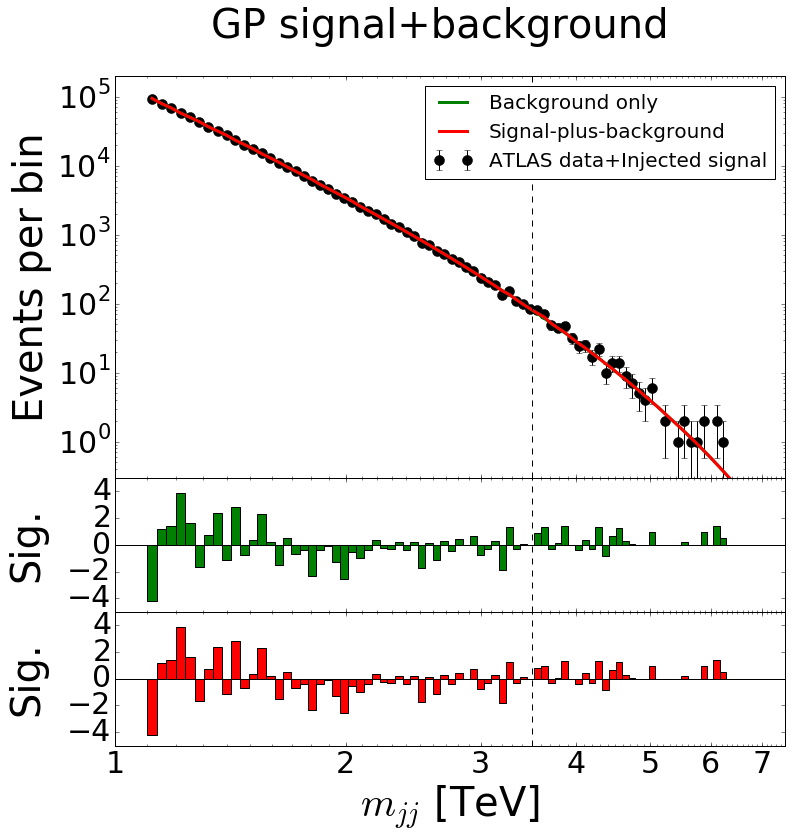

3000
background only time: 0.00290083885193
background + signal time: 0.00346207618713
chi2 bkg+signal mu=0 142.453859398
chi2 bkg+signal 139.62851846


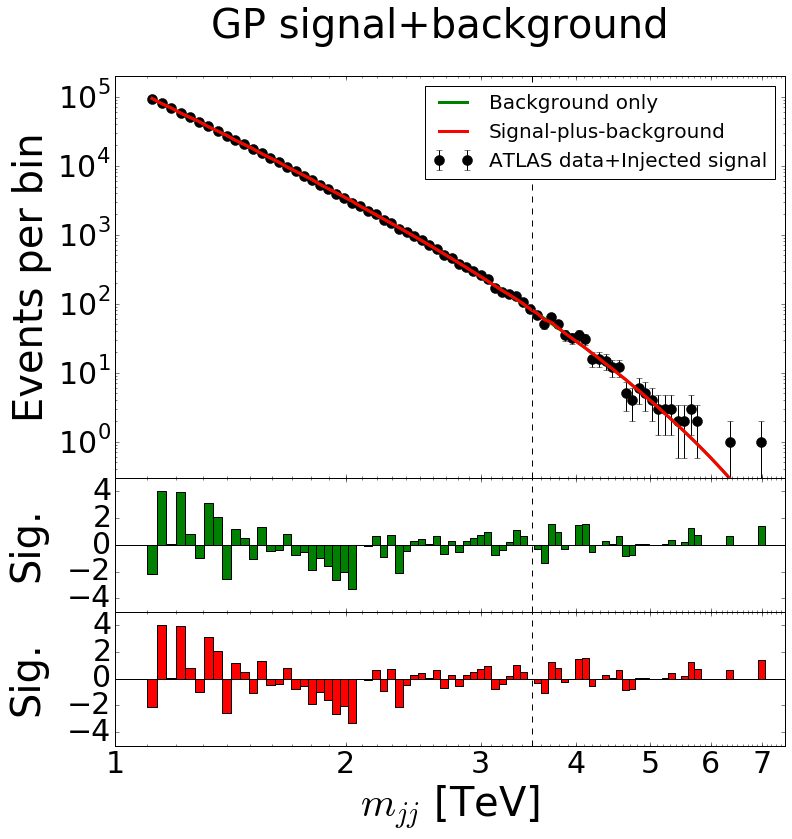

3500
background only time: 0.00285005569458
background + signal time: 0.00338196754456
chi2 bkg+signal mu=0 165.358687785
chi2 bkg+signal 162.516881915


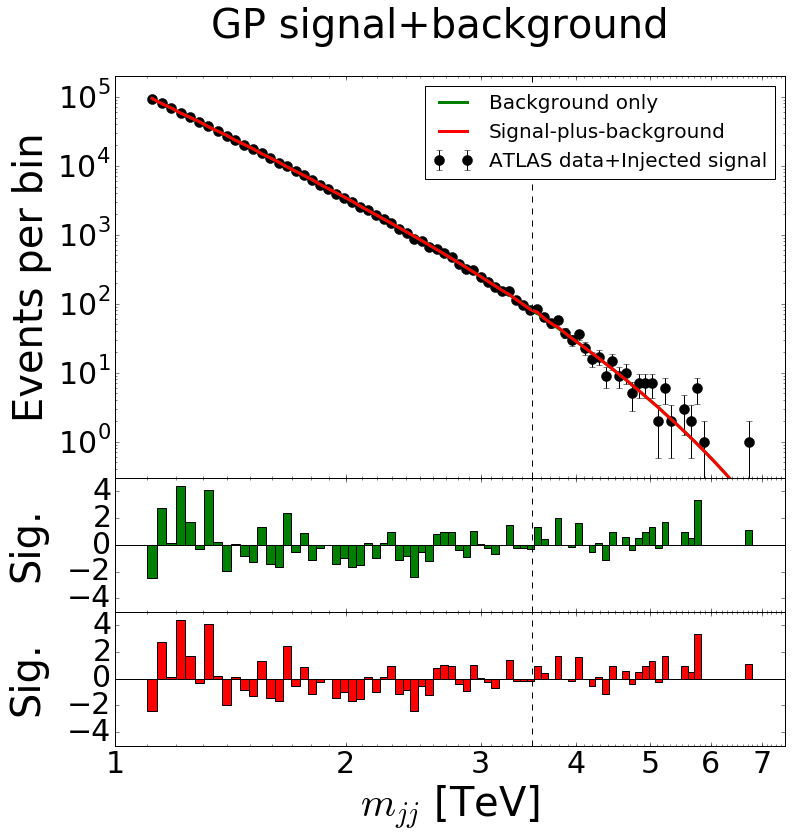

4000
background only time: 0.00303792953491
background + signal time: 0.00341105461121
chi2 bkg+signal mu=0 170.082585653
chi2 bkg+signal 166.185235742


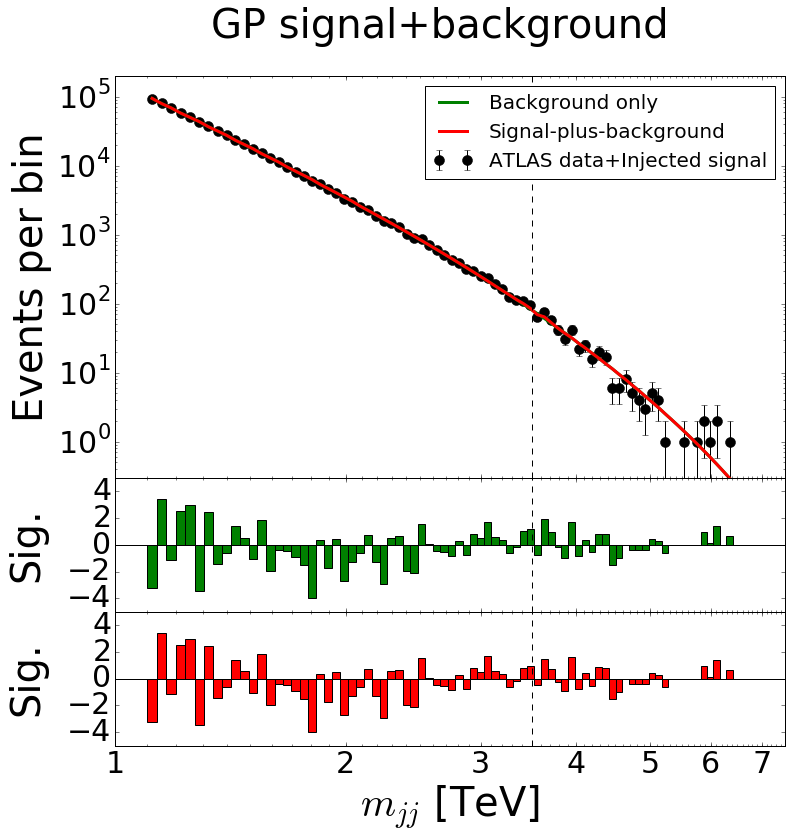

4500
background only time: 0.00294589996338
background + signal time: 0.00337195396423
chi2 bkg+signal mu=0 190.981824715
chi2 bkg+signal 186.633021837


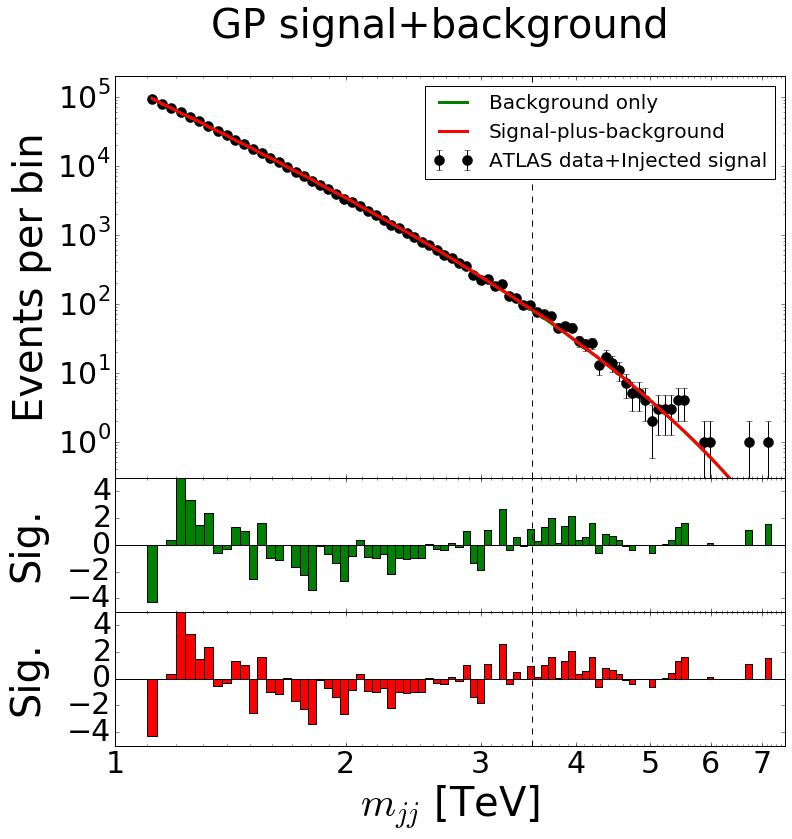

5000
background only time: 0.00301098823547
background + signal time: 0.00348401069641
chi2 bkg+signal mu=0 124.233254981
chi2 bkg+signal 123.35884574


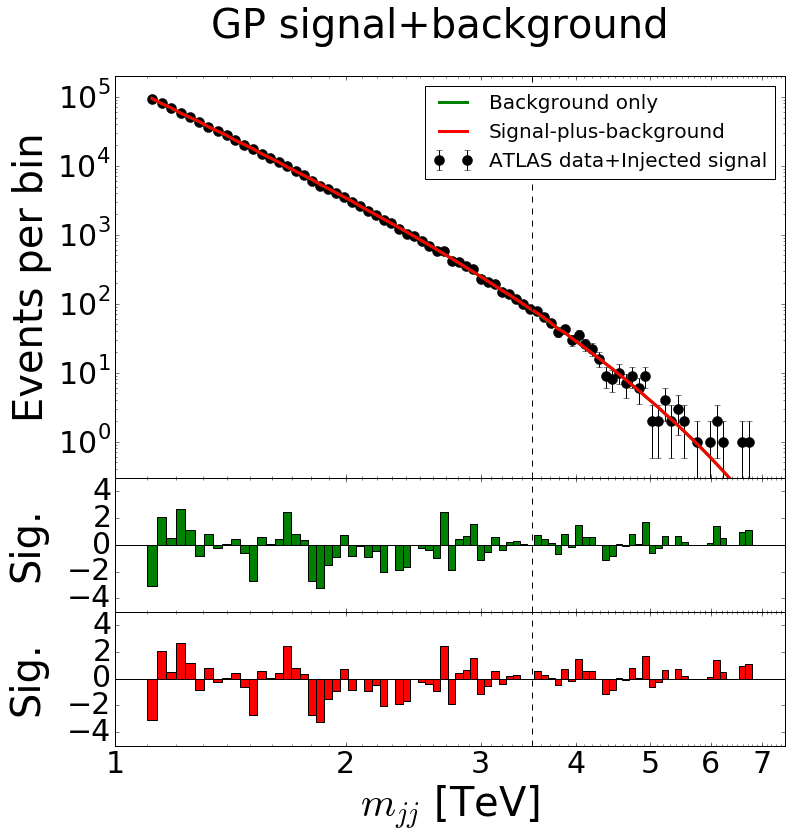

5500
background only time: 0.00321388244629
background + signal time: 0.00347495079041
chi2 bkg+signal mu=0 193.151028895
chi2 bkg+signal 186.607343806


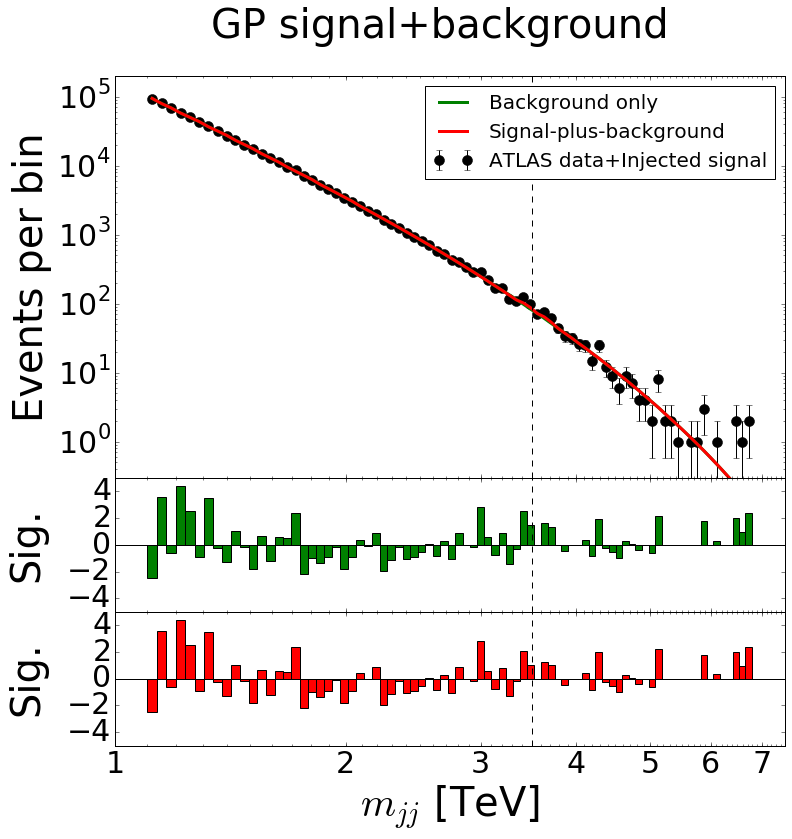

6000
background only time: 0.00296688079834
background + signal time: 0.00340890884399
chi2 bkg+signal mu=0 231.594001778
chi2 bkg+signal 225.746248224


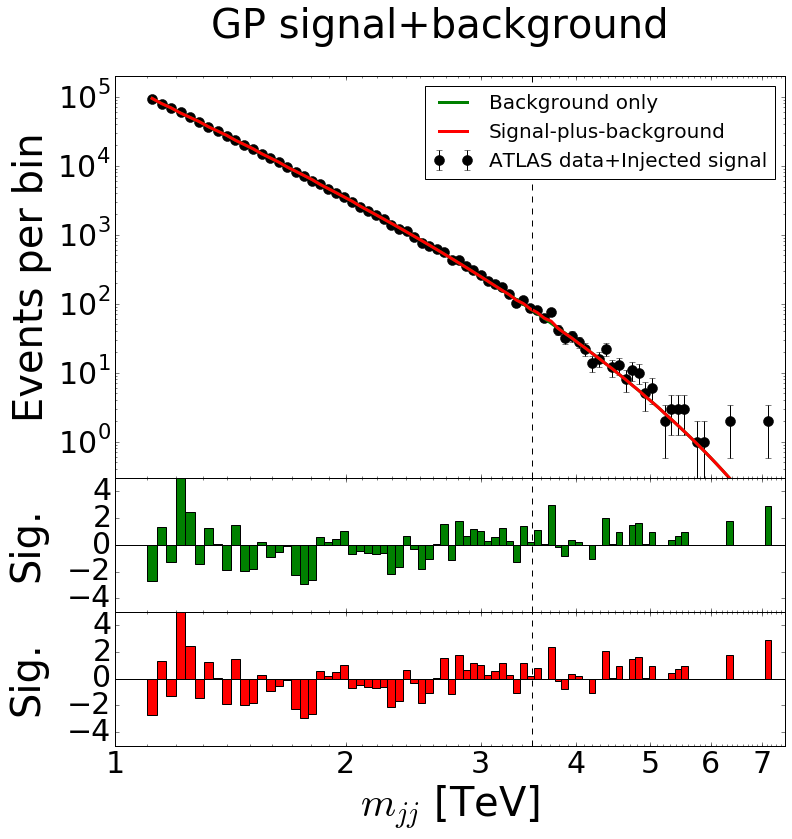

6500
background only time: 0.00316500663757
background + signal time: 0.00342392921448
chi2 bkg+signal mu=0 193.372404827
chi2 bkg+signal 187.952101305


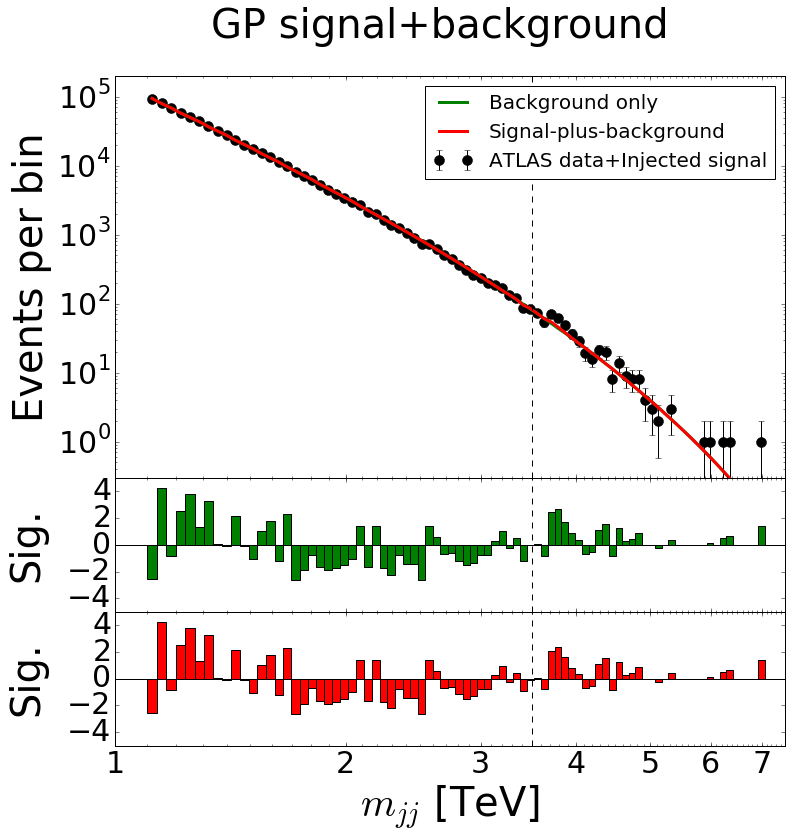

7000
background only time: 0.00355911254883
background + signal time: 0.00379300117493
chi2 bkg+signal mu=0 156.091004313
chi2 bkg+signal 154.495681279


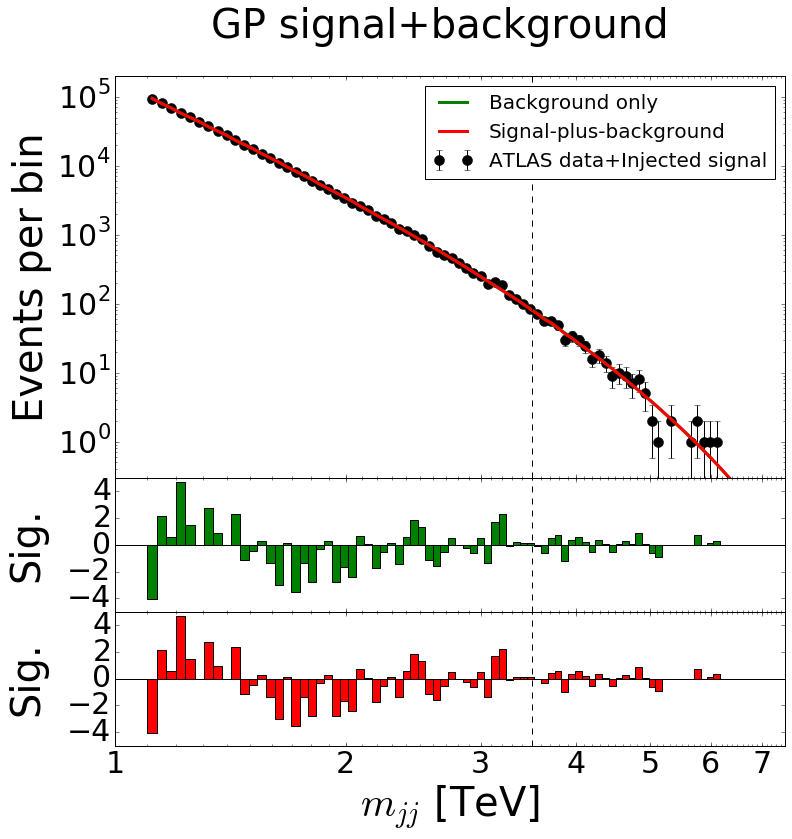

7500
background only time: 0.00362777709961
background + signal time: 0.00411796569824
chi2 bkg+signal mu=0 144.166540606
chi2 bkg+signal 141.954959549


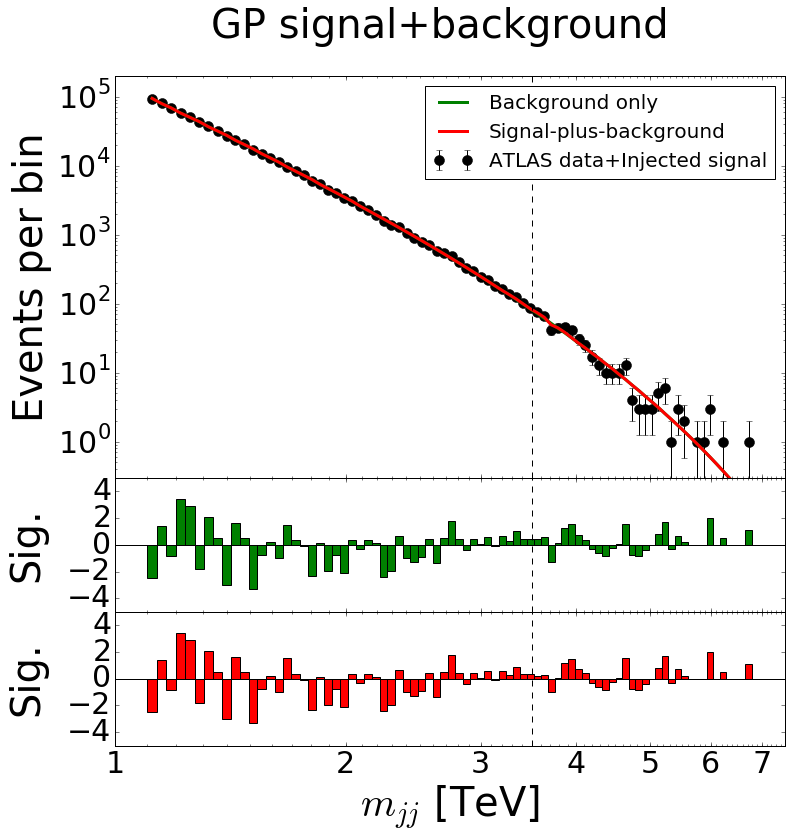

8000
background only time: 0.00309109687805
background + signal time: 0.00356888771057
chi2 bkg+signal mu=0 227.293228764
chi2 bkg+signal 218.309261827


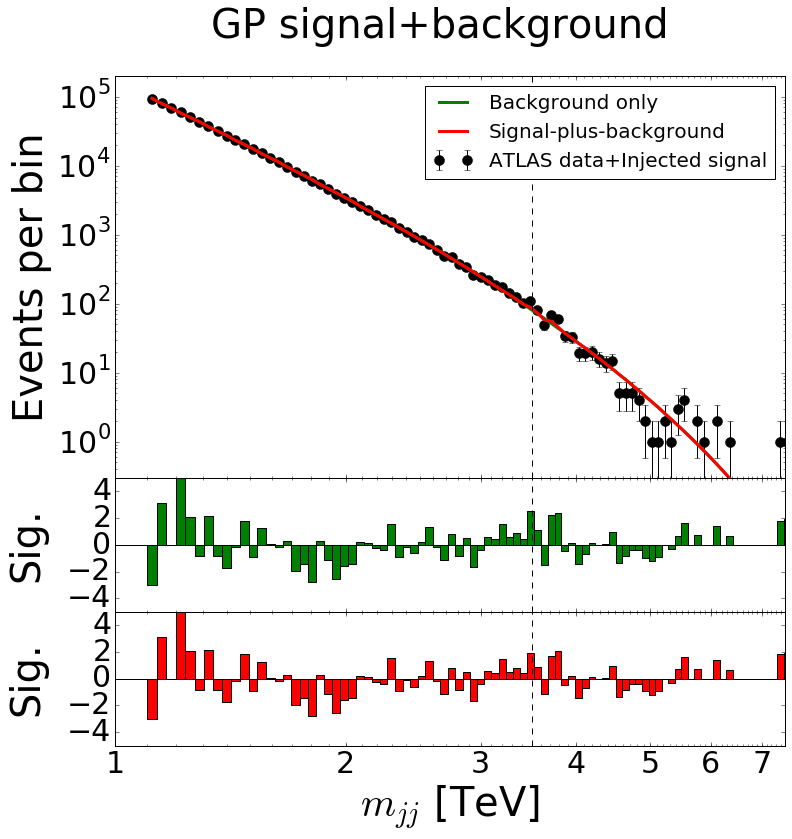

8500
background only time: 0.00295400619507
background + signal time: 0.00350189208984
chi2 bkg+signal mu=0 240.578312891
chi2 bkg+signal 231.317317536


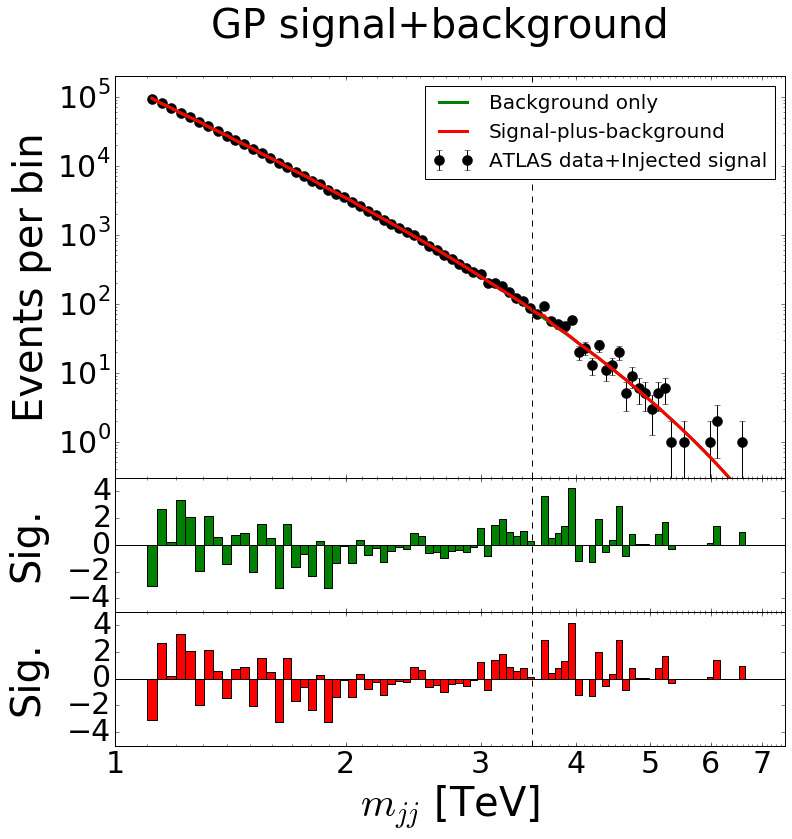

9000
background only time: 0.00307393074036
background + signal time: 0.00380897521973
chi2 bkg+signal mu=0 154.025770042
chi2 bkg+signal 150.922651588


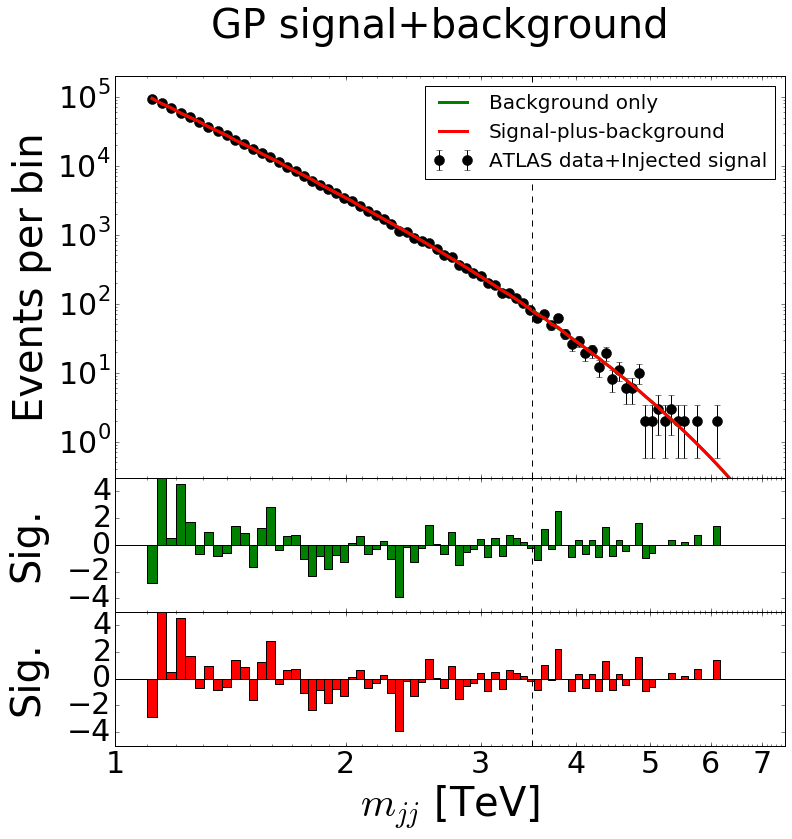

9500
background only time: 0.00310802459717
background + signal time: 0.00348401069641
chi2 bkg+signal mu=0 166.080659072
chi2 bkg+signal 164.287109353


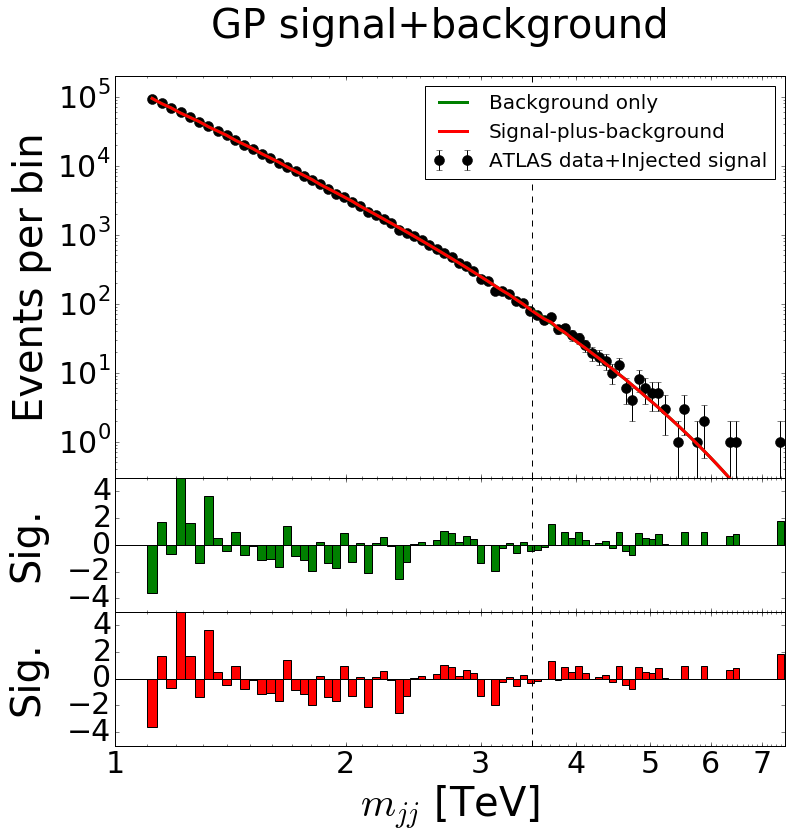

took 0.0324767443869hours


In [30]:
#sigToys = np.load("newoutputs/signalToys_3500.npy")
#sigToysO = np.load("newoutputs/signalToysO_3500.npy")
#toyList = np.load("newoutputs/toyList_3500.npy")
if runOnlyFF: pass
else: 
    btime=time.time()

    #LLH ratio george likelihood
    LLlistGP_smallL={}

    standardParamSets = [(300, 3500, 250)]
    for pSet in standardParamSets:
        n, m, w = pSet
        print pSet
        LLlistGP_smallL[m]=[]

        
        for itoy, toy in enumerate(toyList):
            if not itoy%500: 
                print itoy
            ytoy, xtoy, xtoyerr = removeZeros(toy)
            signalTemplate = sigToys[()][m][itoy]
            ydata = ytoy + signalTemplate

            signalTemplateO = sigToysO[()][m][itoy]
            ydataO = toy + signalTemplateO

            #BACKGROUND ONLY FIT GP
            if not itoy%500:
                pgpb_stime = time.time()
            Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
            kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d = sub)
            gp1 = george.GP(kernel1)
            gp1.compute(xtoy, np.sqrt(ydata))
            MAP1p, covGP1 = gp1.predict(ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)
            MAP1 = MAP1p + model_3param(xvalO,(p0,p1,p2),xerrO)
            gpLLH = gp1.lnlikelihood(ydata - model_gp((p0,p1,p2),xtoy, xtoyerr))
            if not itoy%500:
                pgpb_etime = time.time()
                print "background only time:", pgpb_etime-pgpb_stime

            #BACKGROUND+SIGNAL FIT GP
            if not itoy%500:
                pgpsb_stime = time.time()
            Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
            A, mass, tau, L = 30, 3500, 250, 25
            kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d = sub)
            kernel2 = A * SignalKernel(m = mass, t = tau, L=L)
            kernel = kernel1+kernel2
            gp = george.GP(kernel)
            gp.compute(xtoy, np.sqrt(ydata))
            MAPp, covGP = gp.predict(ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)
            MAP = MAPp + model_3param(xvalO,(p0,p1,p2),xerrO)
            gpLLHSig = gp.lnlikelihood(ydata - model_gp((p0,p1,p2),xtoy, xtoyerr))

            if not itoy%500:
                pgpsb_etime = time.time()
                print "background + signal time:", pgpsb_etime - pgpsb_stime
                makePrettyPlots_signal(xvalO, ydataO, MAP1, MAP, "GP signal+background", 3500, col = 'g', ymax = 2e5)
        

            LLlistGP_smallL[m].append(-2*(gpLLH-gpLLHSig))


    etime = time.time()
    print "took "+str((etime-btime)/(60.*60.)) + "hours"  

george LL% < 0:  55.49
george LL% < 0:  50.29


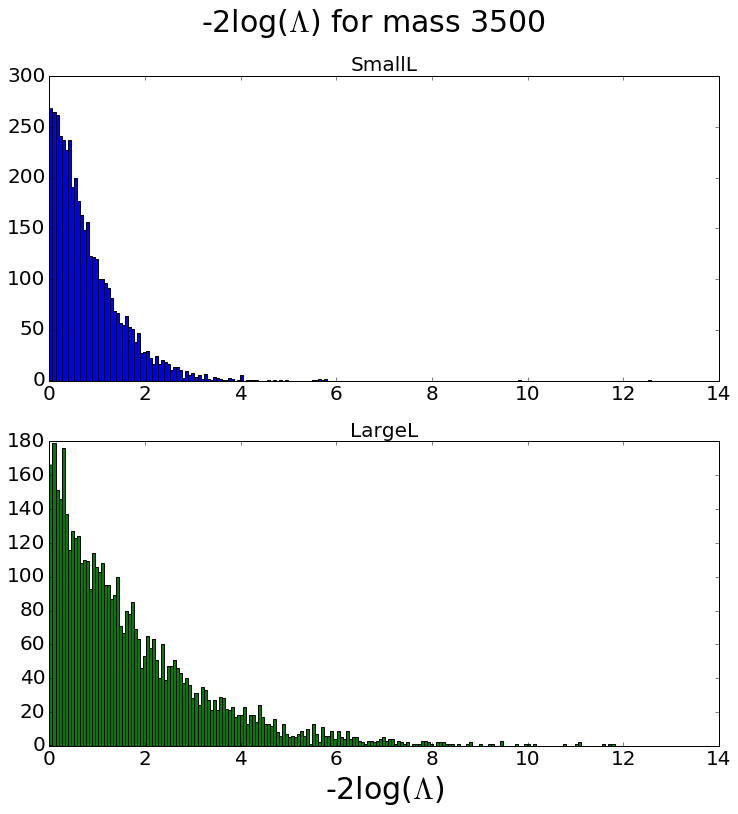

UnboundLocalError: local variable 'bf_params_1' referenced before assignment

In [31]:
msignals = [standardParamSets[i][1] for i in range(len(standardParamSets))]

for m in msignals:
    gp_smallL = [s for s in LLlistGP_smallL[m] if not (np.isinf(s) or np.isnan(s))]
    
    gp_neg_frac_smallL = round(100.*sum(i < 0 for i in gp_smallL)/len(gp_smallL),2)
    print "george LL% < 0: ", gp_neg_frac_smallL
    
    gp_smallL = [s for s in gp_smallL if s > 0]
    
    gp_largeL = [s for s in LLlistGP_largeL[m] if not (np.isinf(s) or np.isnan(s))]
    
    gp_neg_frac_largeL = round(100.*sum(i < 0 for i in gp_largeL)/len(gp_largeL),2)
    print "george LL% < 0: ", gp_neg_frac_largeL
    
    gp_largeL = [s for s in gp_largeL if s > 0]
    
    label = r"-2log($\Lambda$) for mass "+str(int(m))
    makePrettyPlots_LLH(gp_smallL, gp_largeL, label, drawchi2=False, xname = r"-2log($\Lambda$)", label1 ="SmallL", label2 = "LargeL")
    
